In [3]:
import mcmc_utils

In [4]:
import surp
import vice
import numpy as np

import matplotlib.pyplot as plt

from surp.gce_math import Z_to_MH, MH_to_Z
from surp.yields import calc_y

/astro/dboyea/.local/lib/python3.11/site-packages/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [5]:
from singlezone import run_singlezone

In [6]:
surp.set_yields()

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   3.69e-03 MH^2 + 1.96e-03 MH +  1.45 × cristallo11             0.00e+00                       
                    2.20e-03                                                                                     

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       





## Single zone approximation

In [11]:
def agb_interpolator(ele, study, **kwargs):
    return surp.agb_interpolator.interpolator(ele, study=study, **kwargs)

In [6]:
import warnings

the final carbon abundance is
$$
Z_{\rm C}(t_{\rm end}) = \frac{y_{\rm C}}{1+\eta - r - \tau_{\star} / \tau_{\rm sfh}}
$$

In [32]:
def calc_y_sz(ele="c", ignore_warnings=True):
    if ignore_warnings:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sz, h = run_singlezone()
    
    Z_end = h[f"z({ele})"].iloc[-1]
    tau_star = 2.5
    η = 0.5
    r = 0.4
    tau_sfh = 14
    
    y0 = Z_end * (1 + η - r - tau_star / tau_sfh)
    
    return y0

In [33]:
vice.yields.ccsne.settings["fe"] + vice.yields.sneia.settings["fe"]

0.001243

In [34]:
calc_y_sz("fe")

0.0012628892546872612

In [37]:
vice.yields.ccsne.settings["c"] = 1e-4
vice.yields.agb.settings["c"] = agb_interpolator("c", study="cristallo11", prefactor=0)

calc_y_sz("c")

0.00010060020617254566

In [38]:
vice.yields.ccsne.settings["c"] = 0

for model in surp.AGB_MODELS:
    vice.yields.agb.settings["c"] = agb_interpolator("c", study=model)
    y = calc_y_sz("c")

    print(model, "\t", f"{y:0.3e}")


cristallo11 	 4.605e-04
ventura13 	 3.334e-04
karakas16 	 5.403e-04
pignatari16 	 7.294e-04


In [40]:
for m_factor in [0.5, 0.8, 1, 1.3, 2]:
    vice.yields.agb.settings["c"] = agb_interpolator("c", study="cristallo11", mass_factor=m_factor)
    y = calc_y_sz("c")

    print(m_factor, "\t", f"{y:0.3e}")

0.5 	 5.084e-04
0.8 	 5.486e-04
1 	 4.605e-04
1.3 	 4.126e-04
2 	 3.594e-04


# MCMC Fits

# Prior models

In [7]:
lin_model = mcmc_utils.Linear(beta0=[3e-4, 3e-4], beta1=[0, 6e-4], log_sigma=[-20, 1])
exp_model = mcmc_utils.Exponential(beta0=[3e-4, 3e-3], beta1=[0,2e-2], log_sigma=[-20, 1])
quad_model = mcmc_utils.Quadratic(beta0=[3e-4, 3e-4], beta1=[0, 3e-4], beta2=[0, 3e-4], log_sigma=[-20, 1])

In [8]:
N = 3_000
discard = 300

You must install the tqdm library to use progress indicators with emcee


$\beta_0$ = 3.05e-04 + 3.13e-04 - 3.31e-04
$\beta_1$ = 1.06e-05 + 6.28e-04 - 6.20e-04
$\log(\sigma)$ = -1.99e+01 + 9.52e-01 - 9.98e-01


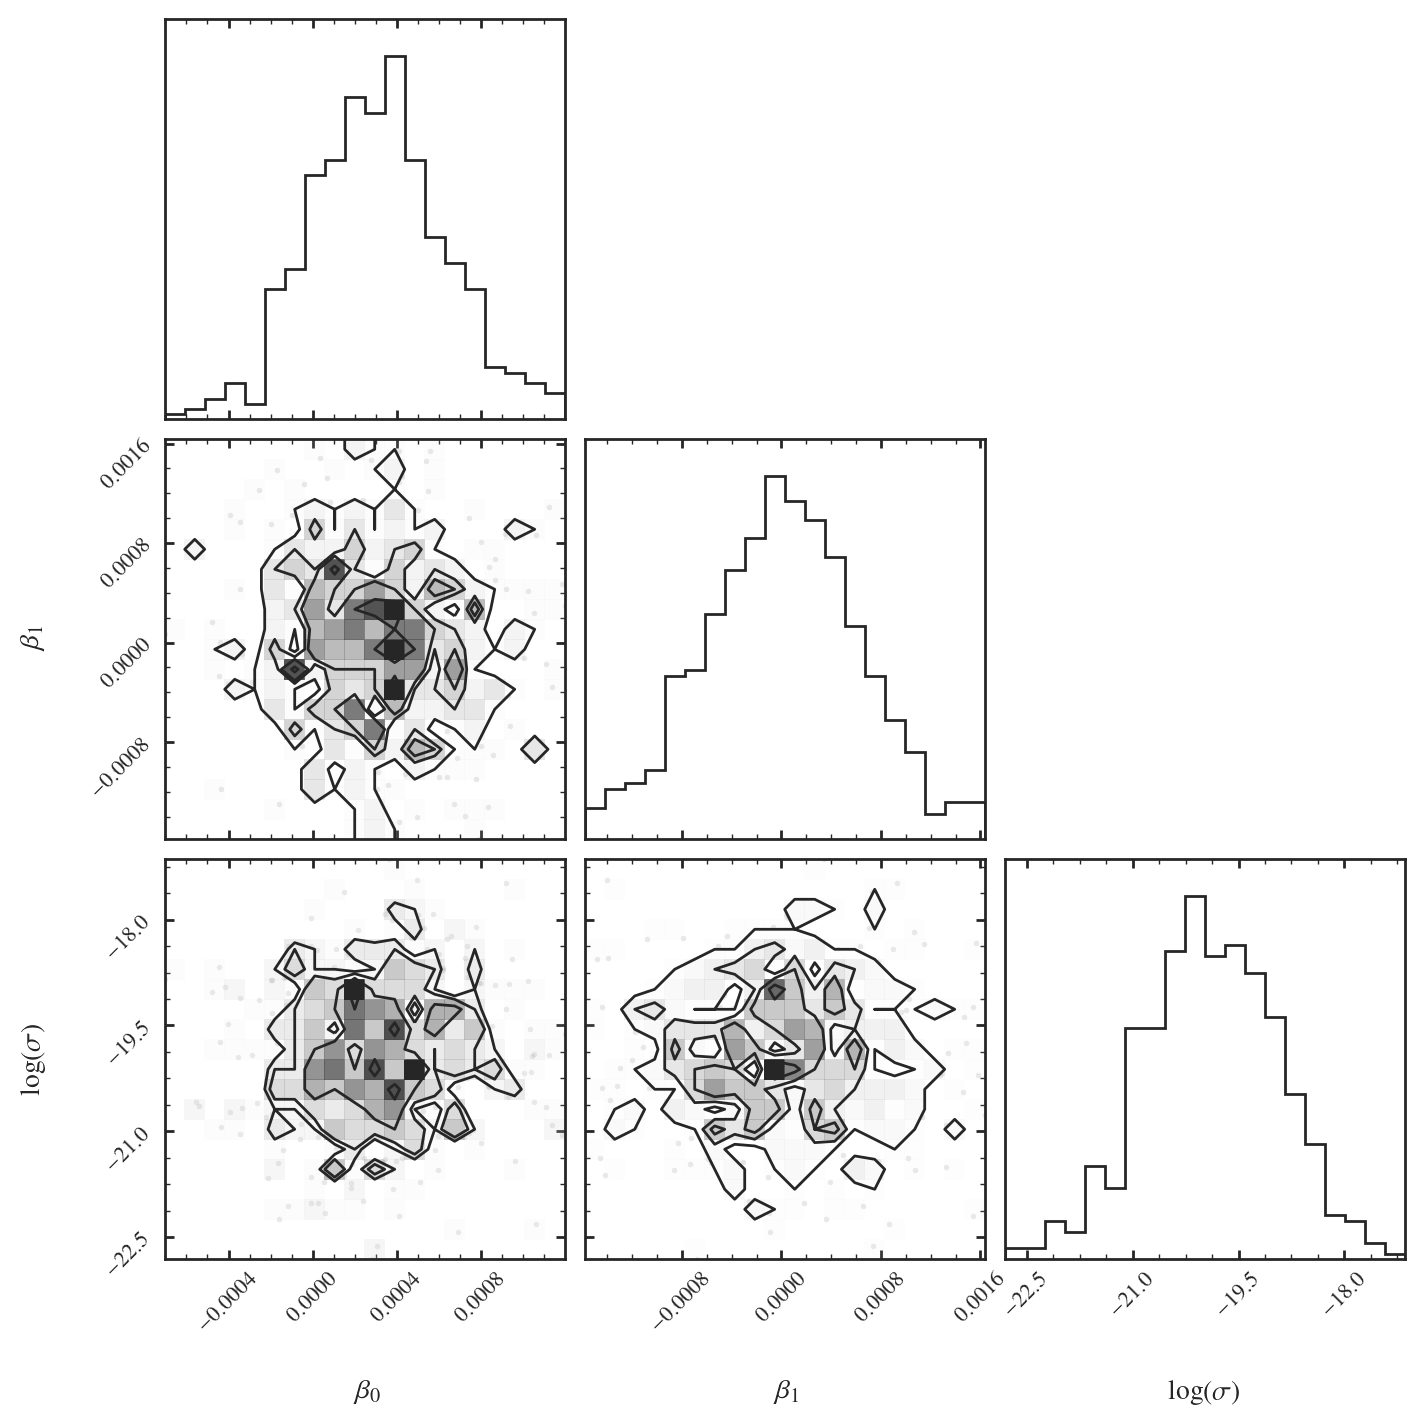

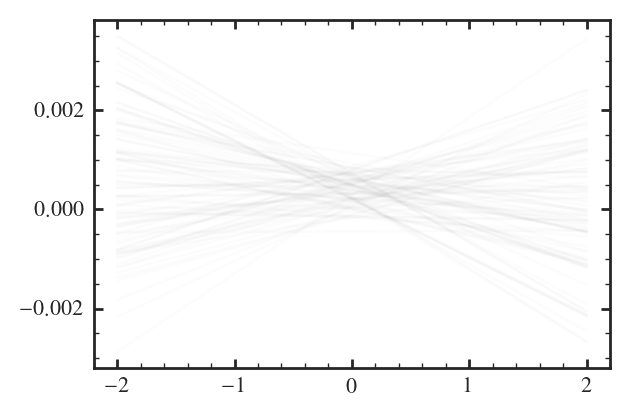

In [9]:
mcmc_utils.plot_prior(lin_model)

100%|██████████| 1000/1000 [00:11<00:00, 83.97it/s]


$\beta_0$ = 7.11e-04 + 3.19e-03 - 3.28e-03
$\beta_1$ = -2.21e-03 + 1.84e-02 - 2.06e-02
$\log(\sigma)$ = -2.00e+01 + 1.00e+00 - 9.76e-01


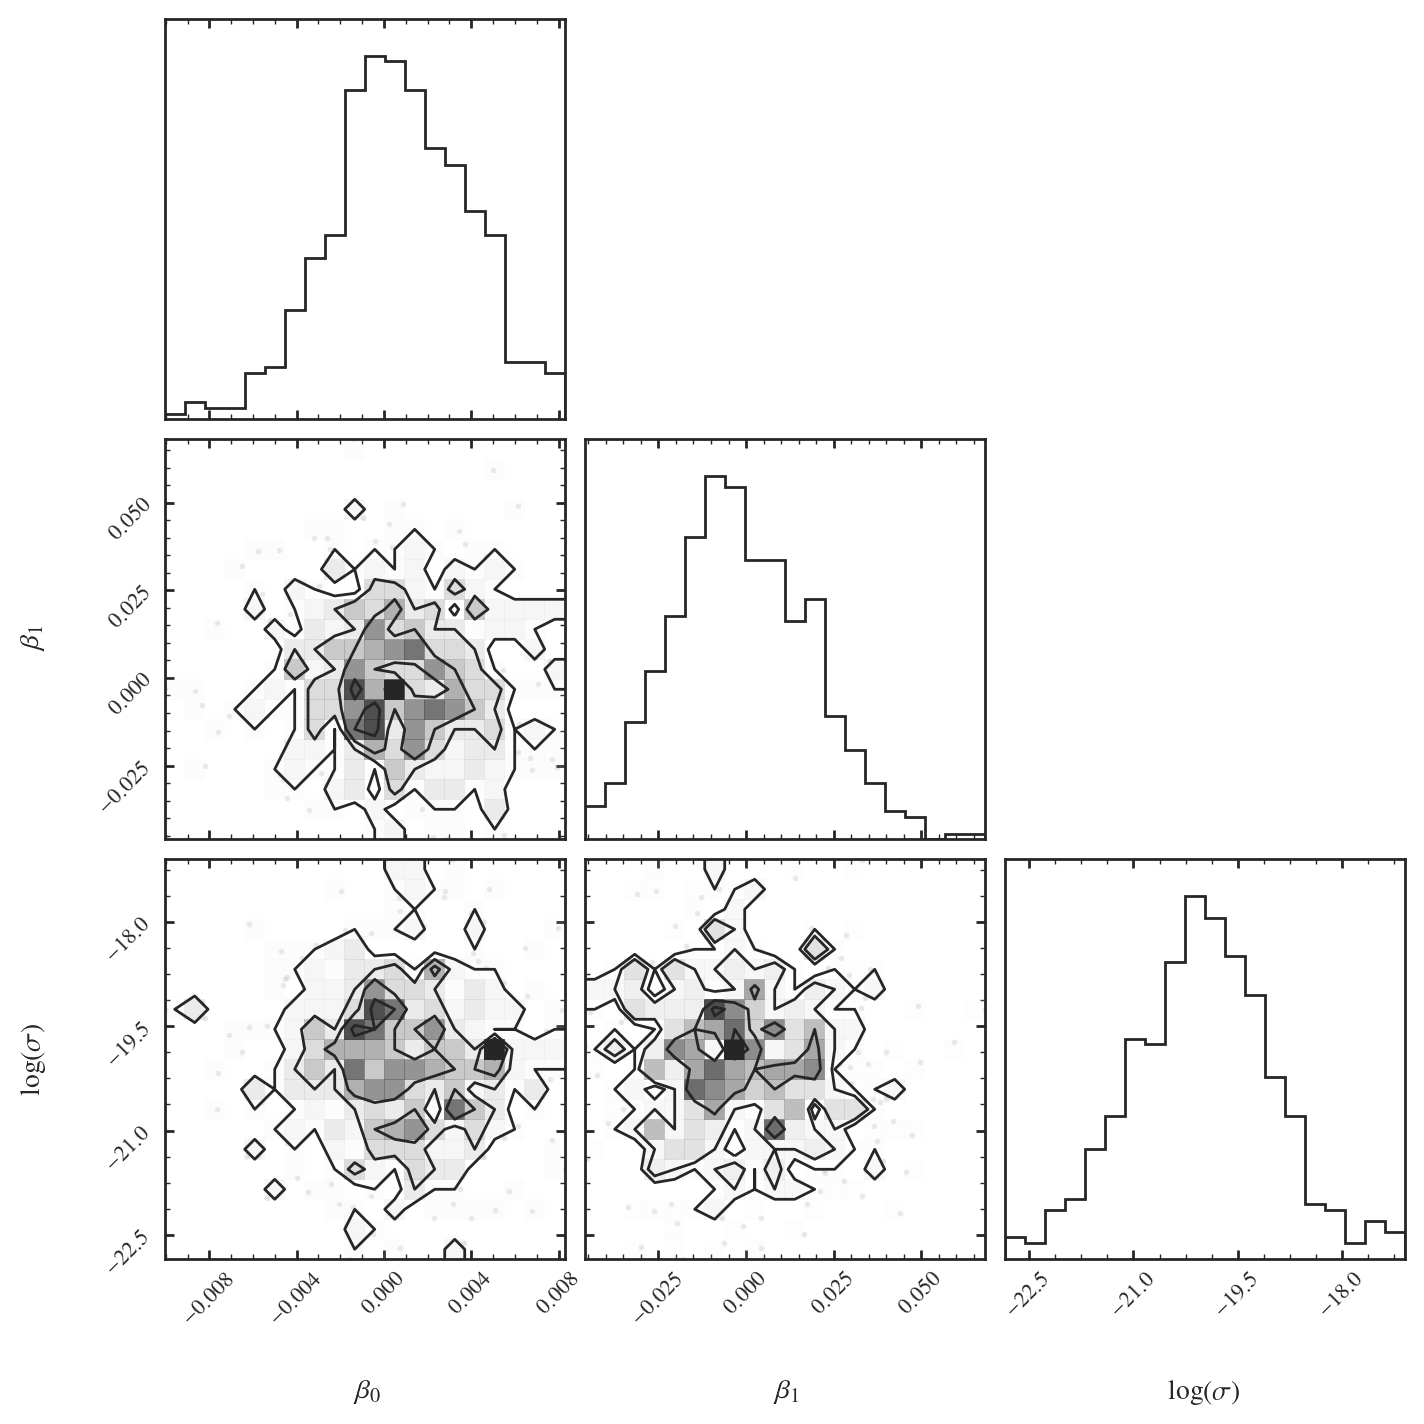

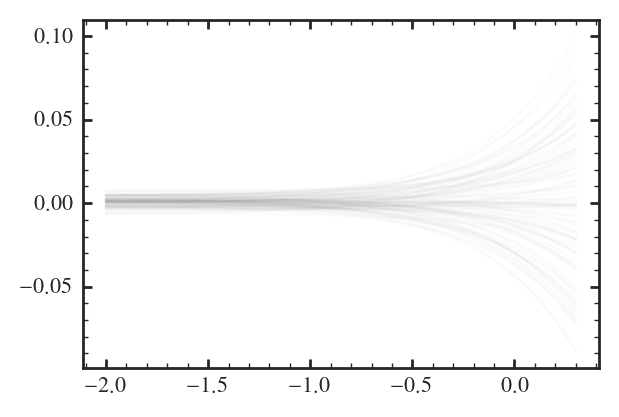

In [44]:
mcmc_utils.plot_prior(exp_model, xlims=(-2, 0.3))

100%|██████████| 1000/1000 [00:13<00:00, 76.86it/s]


$\beta_0$ = 3.08e-04 + 2.95e-04 - 2.74e-04
$\beta_1$ = -2.78e-05 + 3.21e-04 - 2.88e-04
$\beta_2$ = 4.80e-05 + 2.68e-04 - 3.00e-04
$\log(\sigma)$ = -2.00e+01 + 9.98e-01 - 9.43e-01


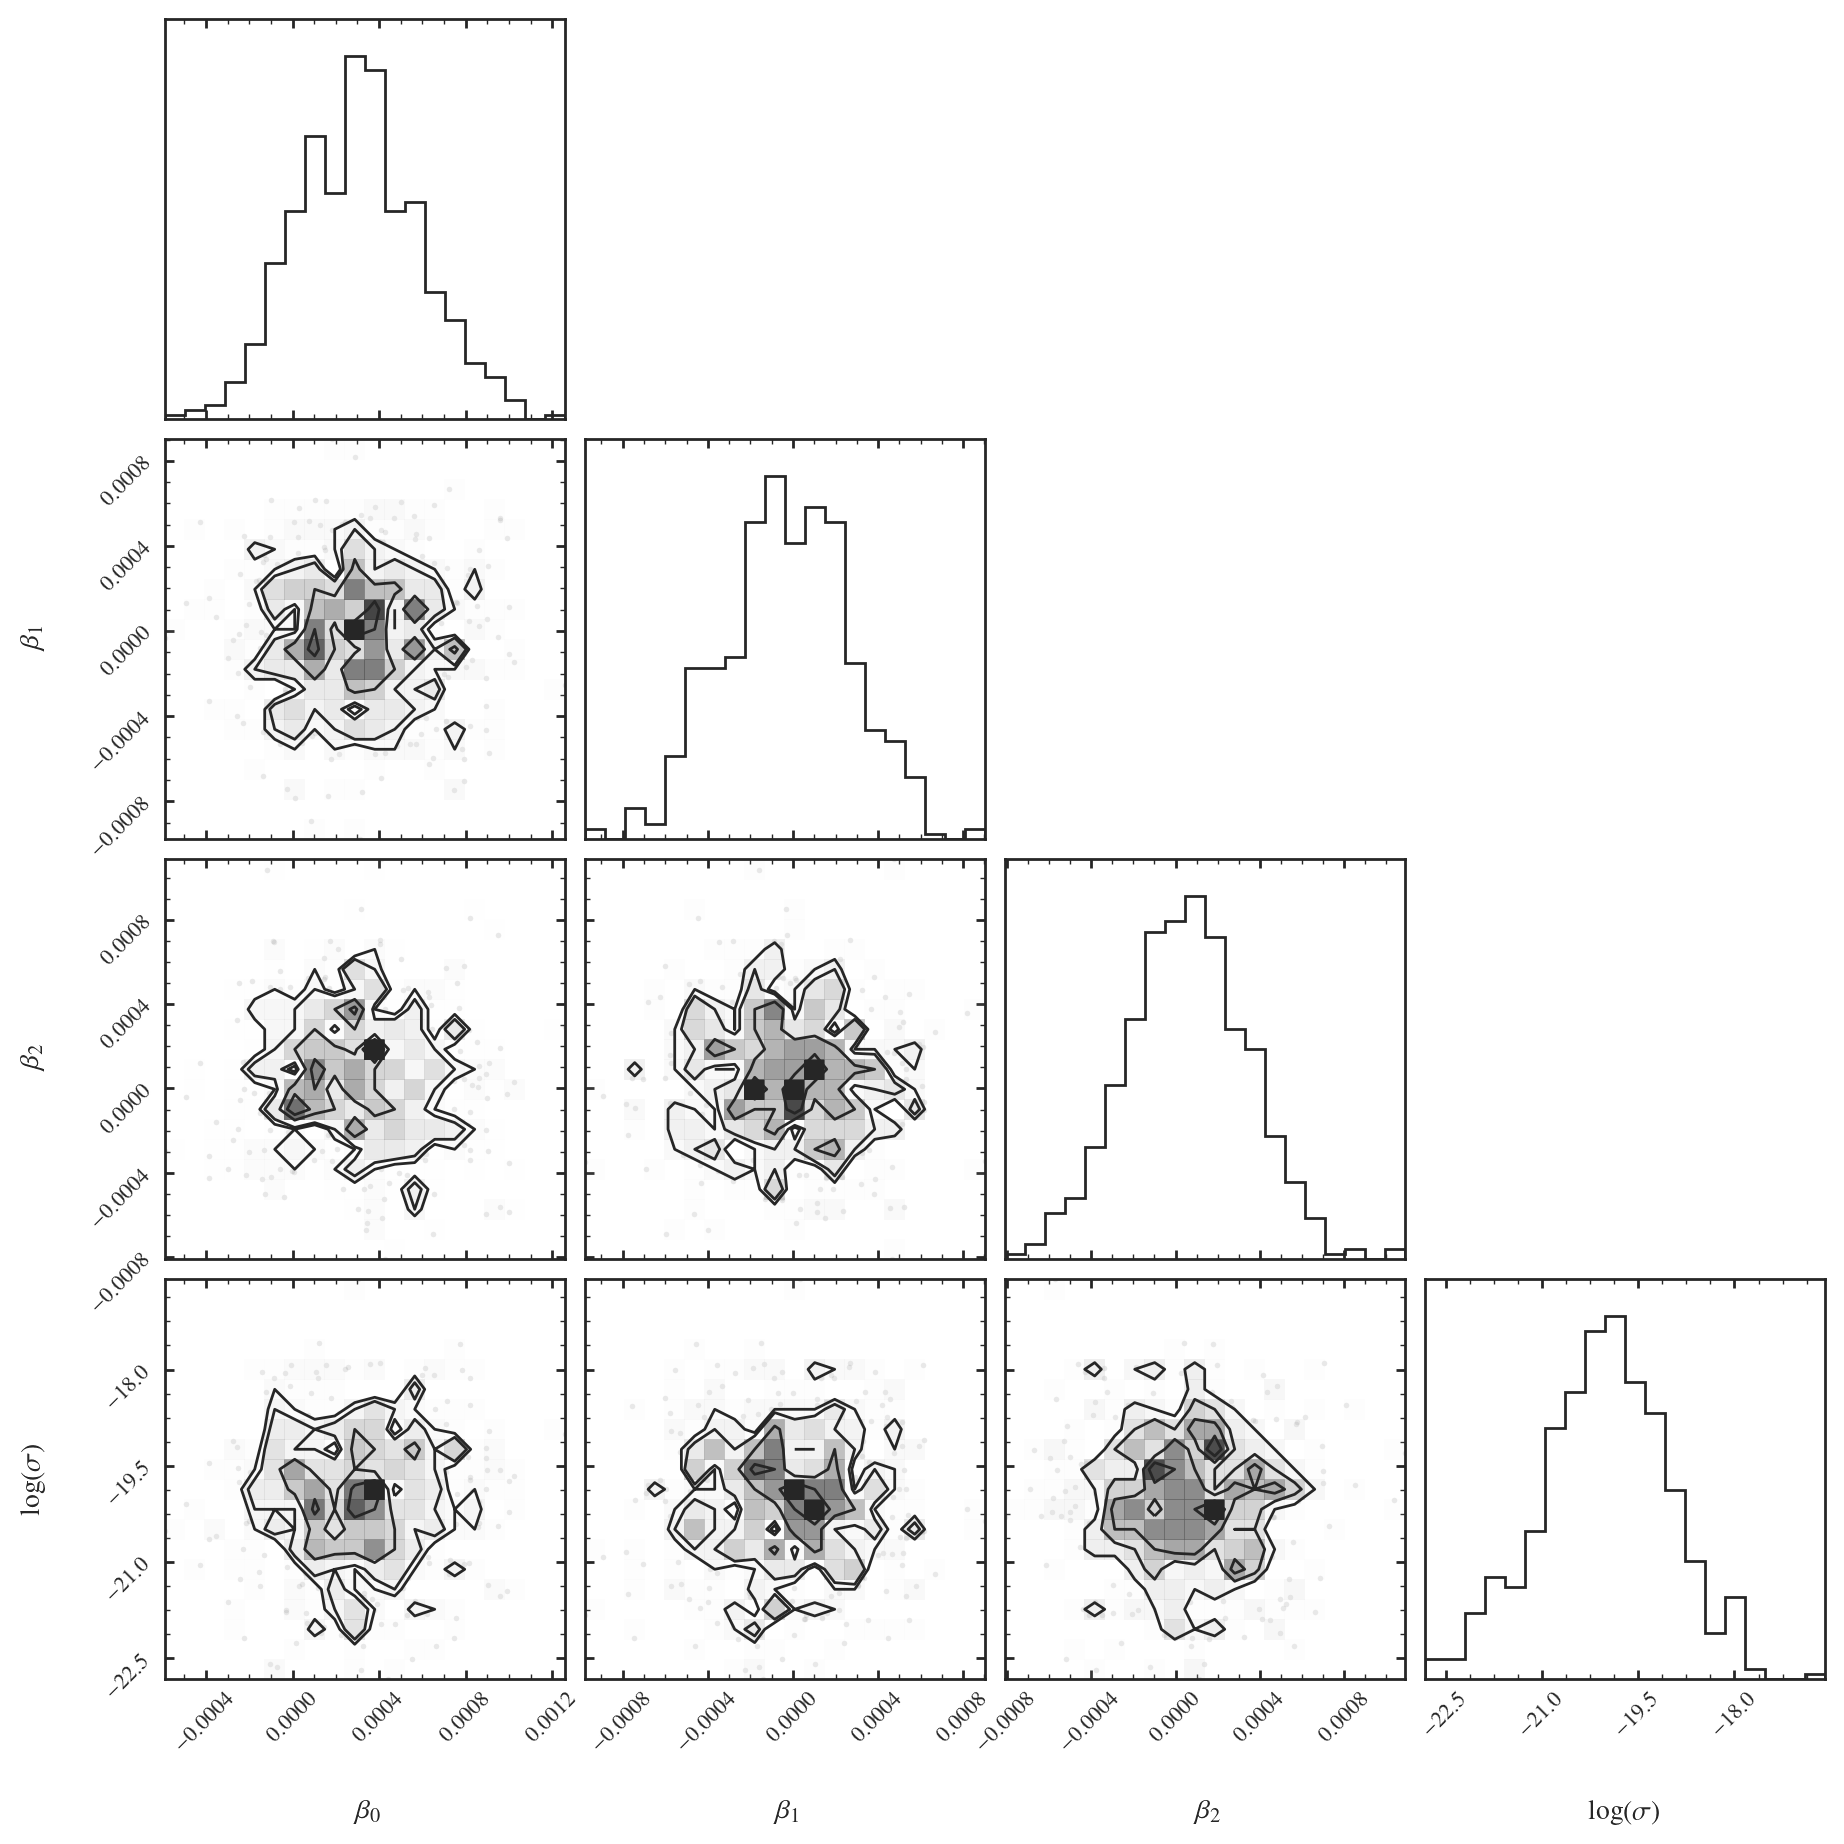

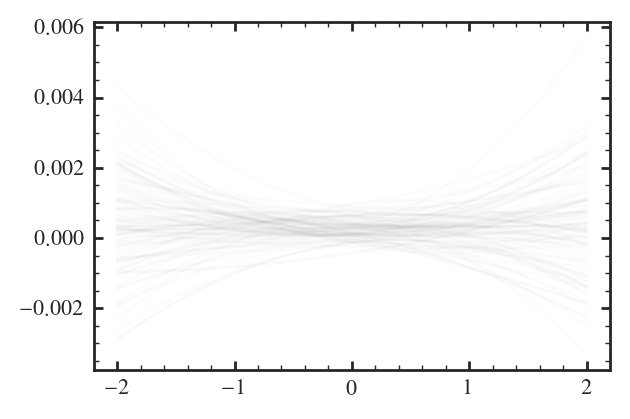

In [45]:
mcmc_utils.plot_prior(quad_model)

# Fit to the yield tables

In [91]:
def get_yield_table(study, **kwargs):
    y1, m1, z1 = vice.yields.agb.grid("c", study=study)
    mh1 = Z_to_MH(z1)
    vice.yields.agb.settings["c"] = agb_interpolator("c", study=study, **kwargs)
    y_c_agb1 = np.array([calc_y(z) for z in z1])

    return mh1, y_c_agb1, None, None

In [47]:
obs = get_yield_table("cristallo11")

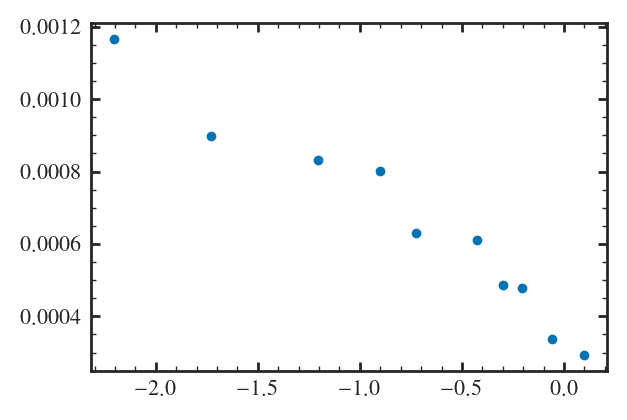

In [48]:
plt.scatter(obs[0], obs[1])

100%|██████████| 3000/3000 [00:12<00:00, 241.80it/s]


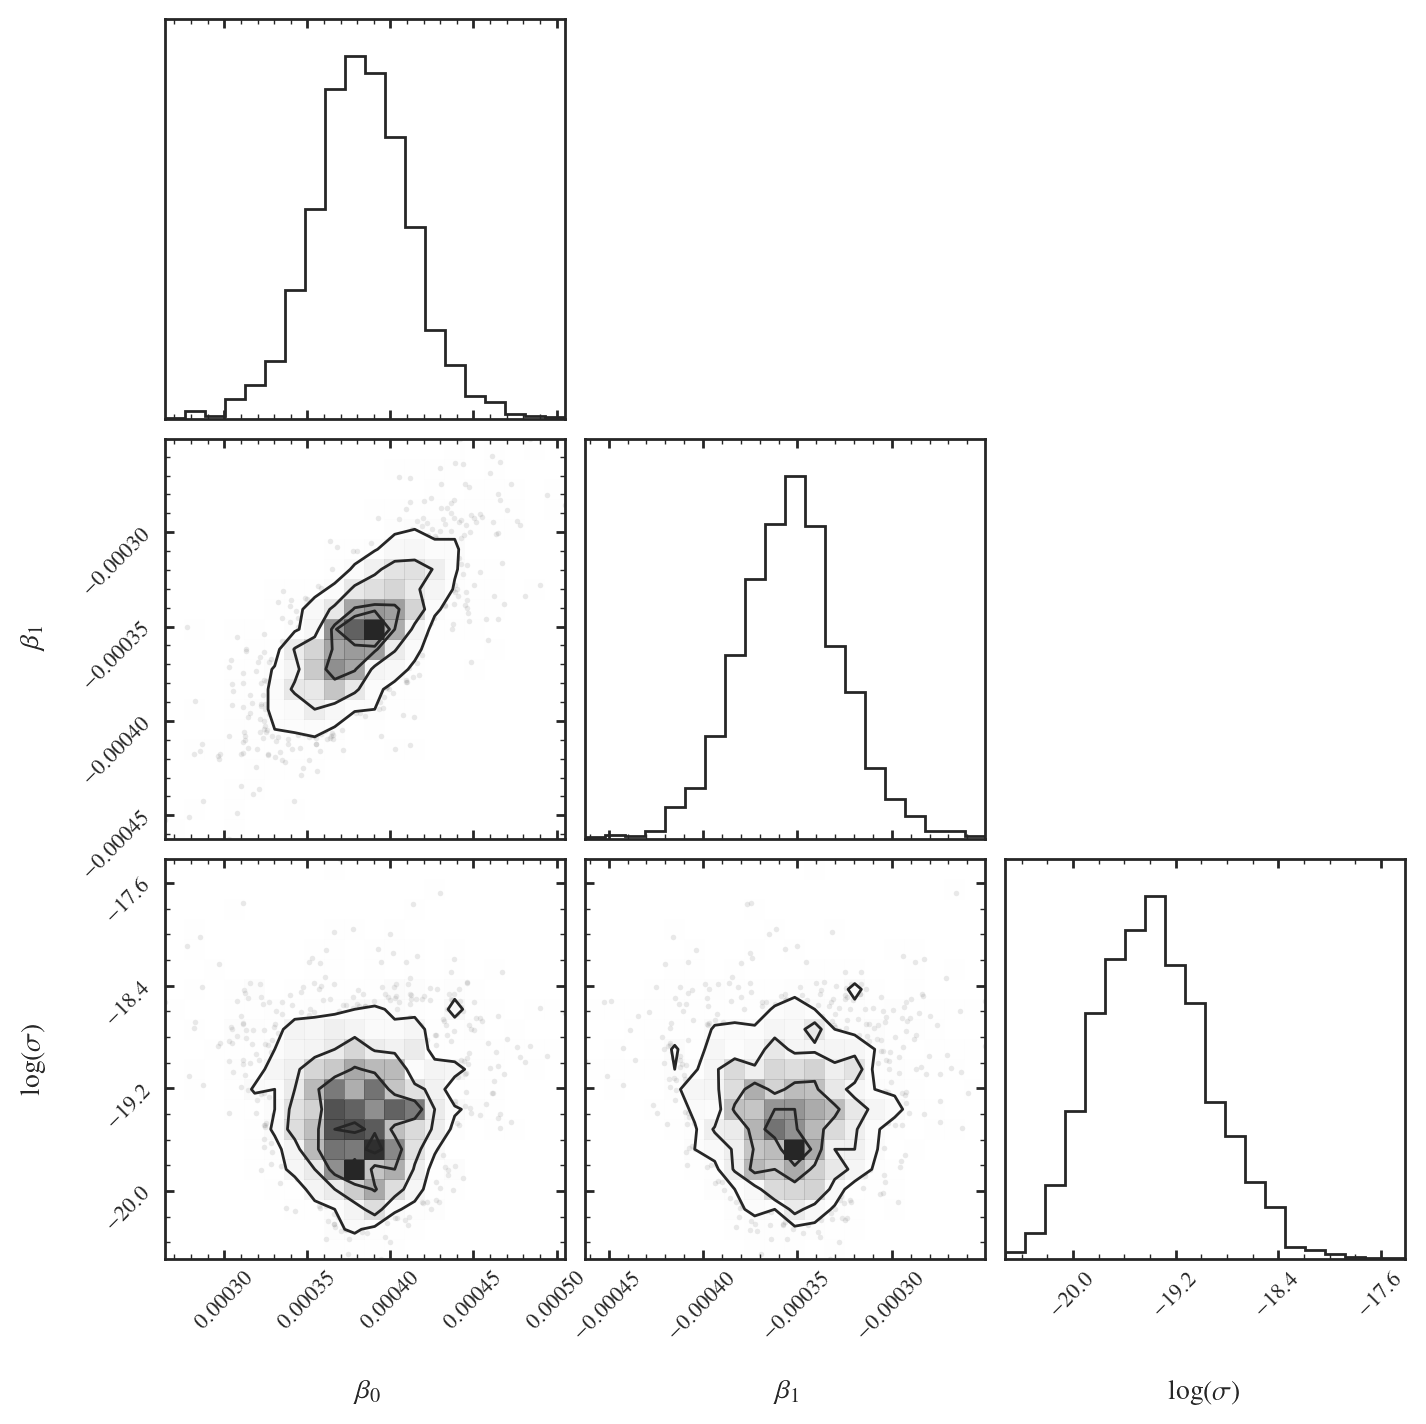

In [49]:
samples = mcmc_utils.run_mcmc(lin_model, obs, N=N, discard=discard)

$\beta_0$ = 3.82e-04 + 2.79e-05 - 2.83e-05
$\beta_1$ = -3.54e-04 + 2.65e-05 - 2.58e-05
$\log(\sigma)$ = -1.94e+01 + 4.17e-01 - 4.58e-01


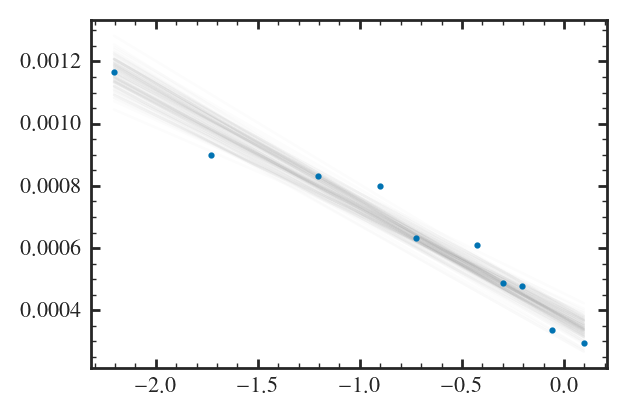

In [50]:
mcmc_utils.plot_posterior(lin_model, obs, samples)

100%|██████████| 3000/3000 [00:14<00:00, 212.59it/s]


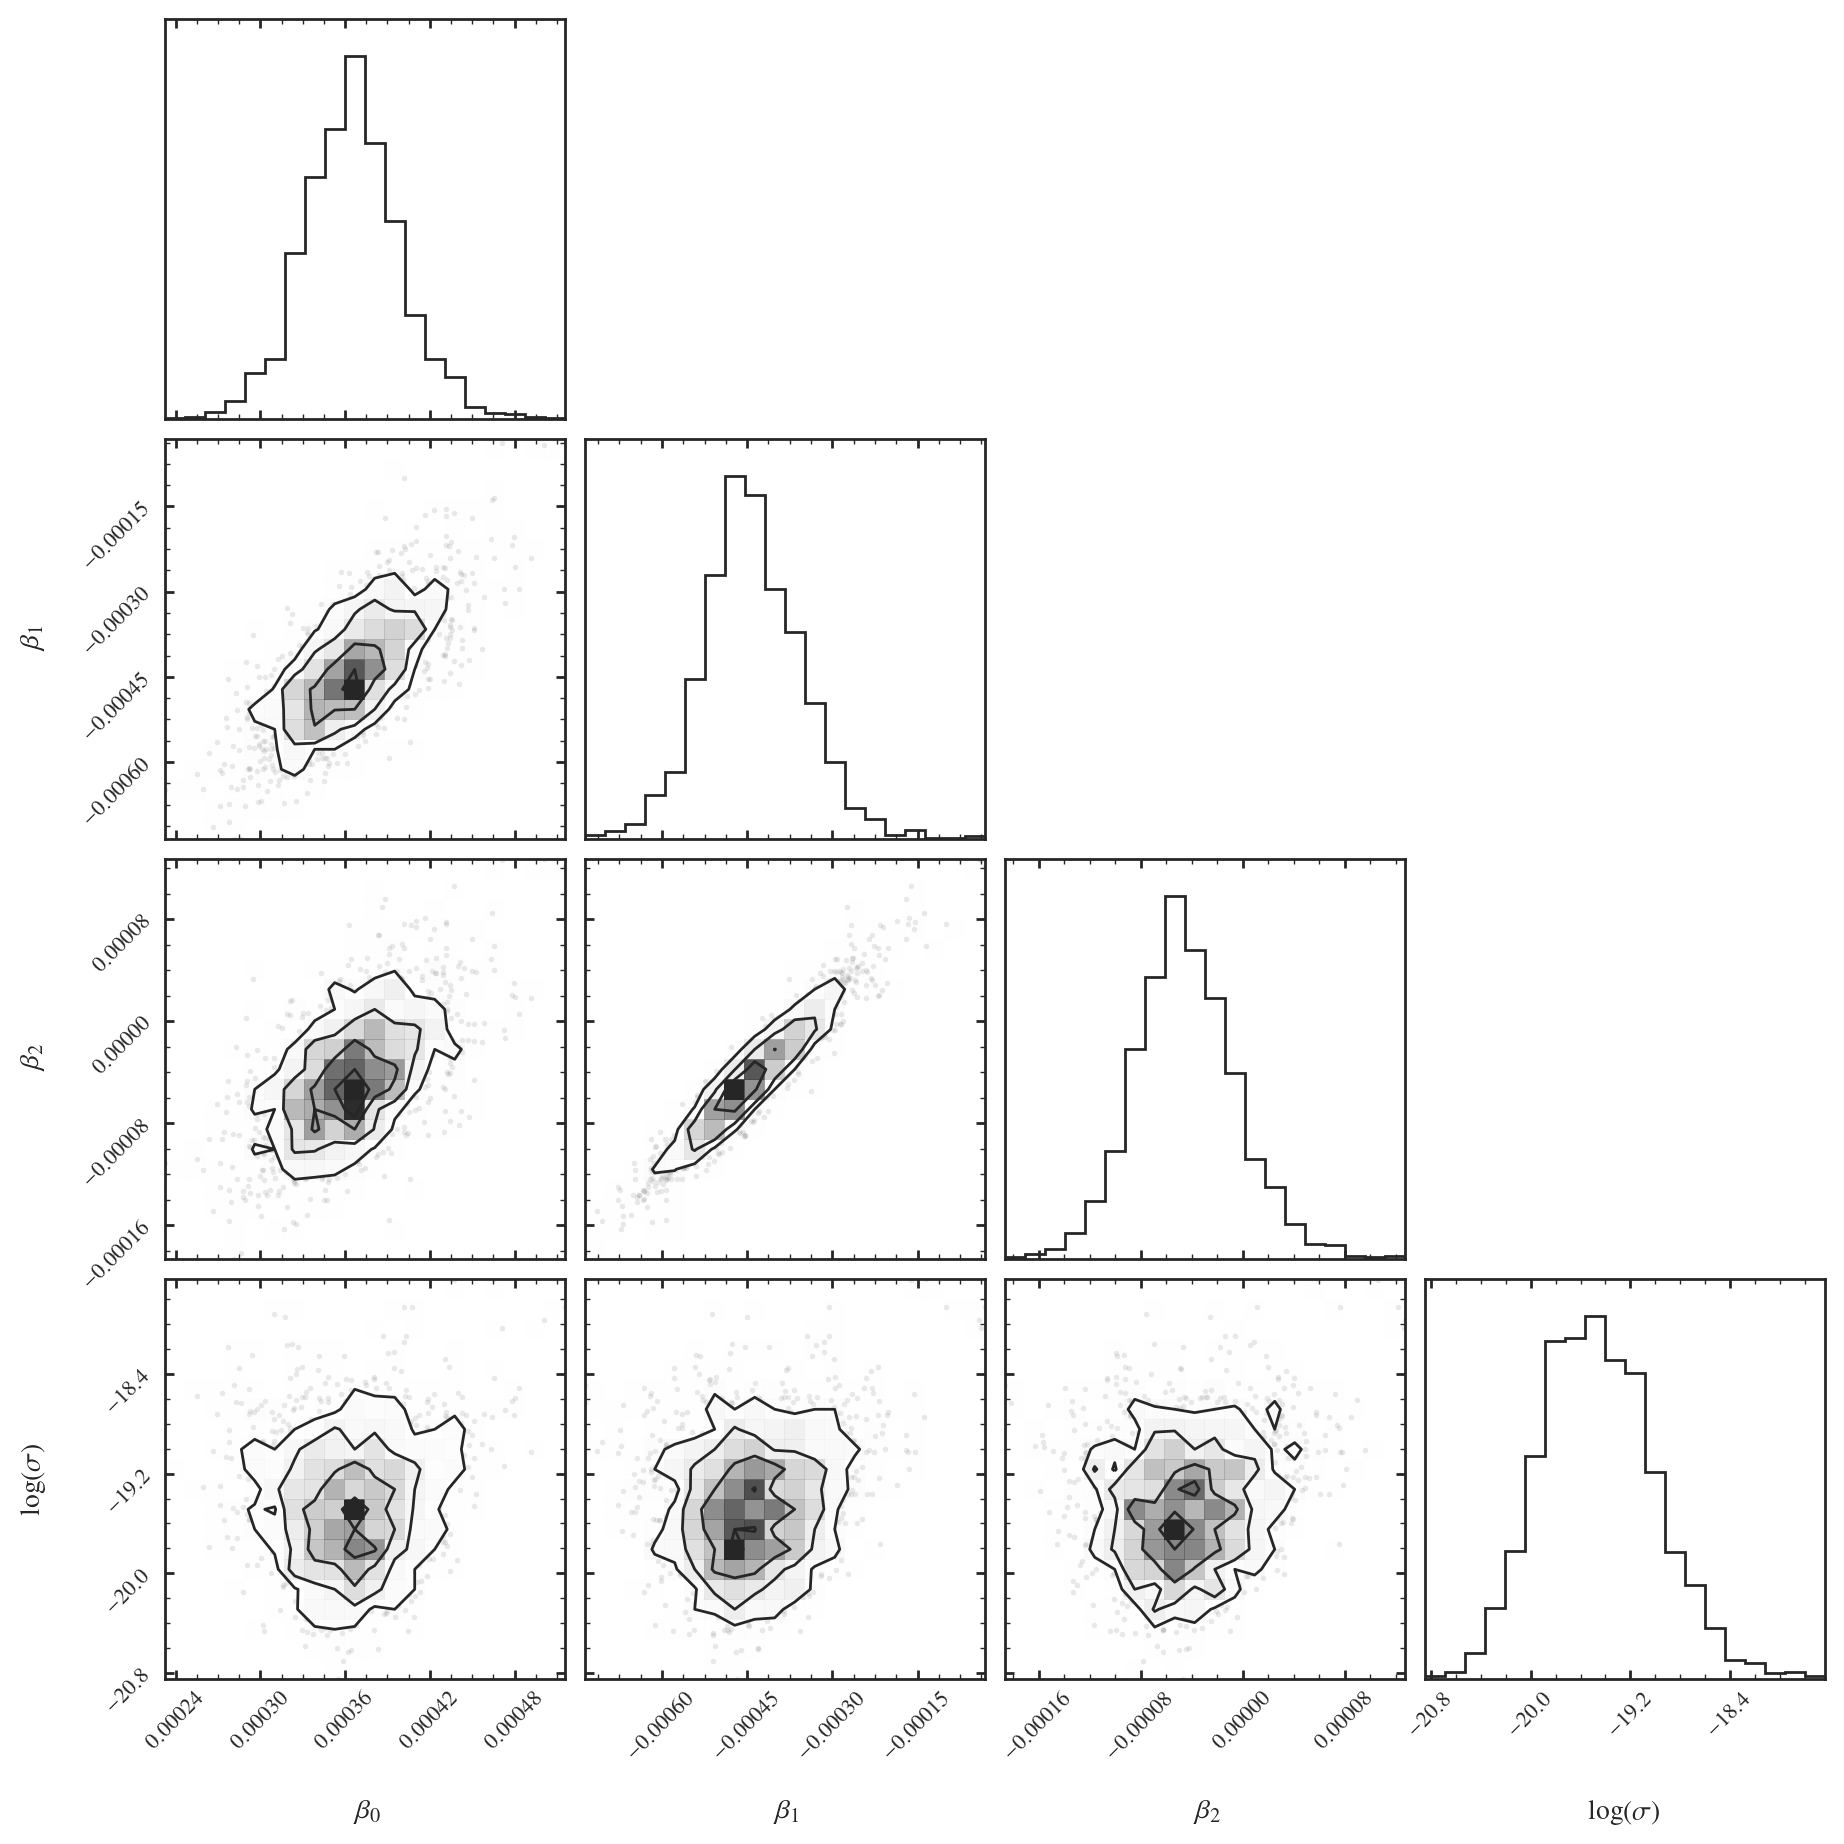

In [51]:
samples = mcmc_utils.run_mcmc(quad_model, obs, N=N, discard=discard)

$\beta_0$ = 3.64e-04 + 3.20e-05 - 3.22e-05
$\beta_1$ = -4.46e-04 + 7.53e-05 - 8.92e-05
$\beta_2$ = -4.66e-05 + 3.69e-05 - 4.00e-05
$\log(\sigma)$ = -1.95e+01 + 4.10e-01 - 4.83e-01


(-0.0003, 0.002)

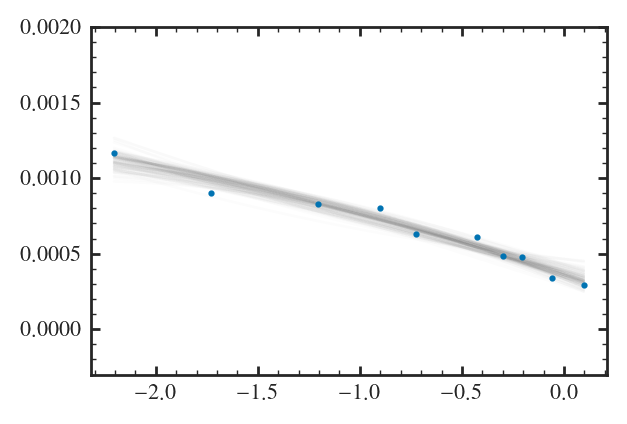

In [52]:
mcmc_utils.plot_posterior(quad_model, obs, samples)
plt.ylim(-0.3e-3, 2e-3)

100%|██████████| 3000/3000 [00:12<00:00, 243.90it/s]


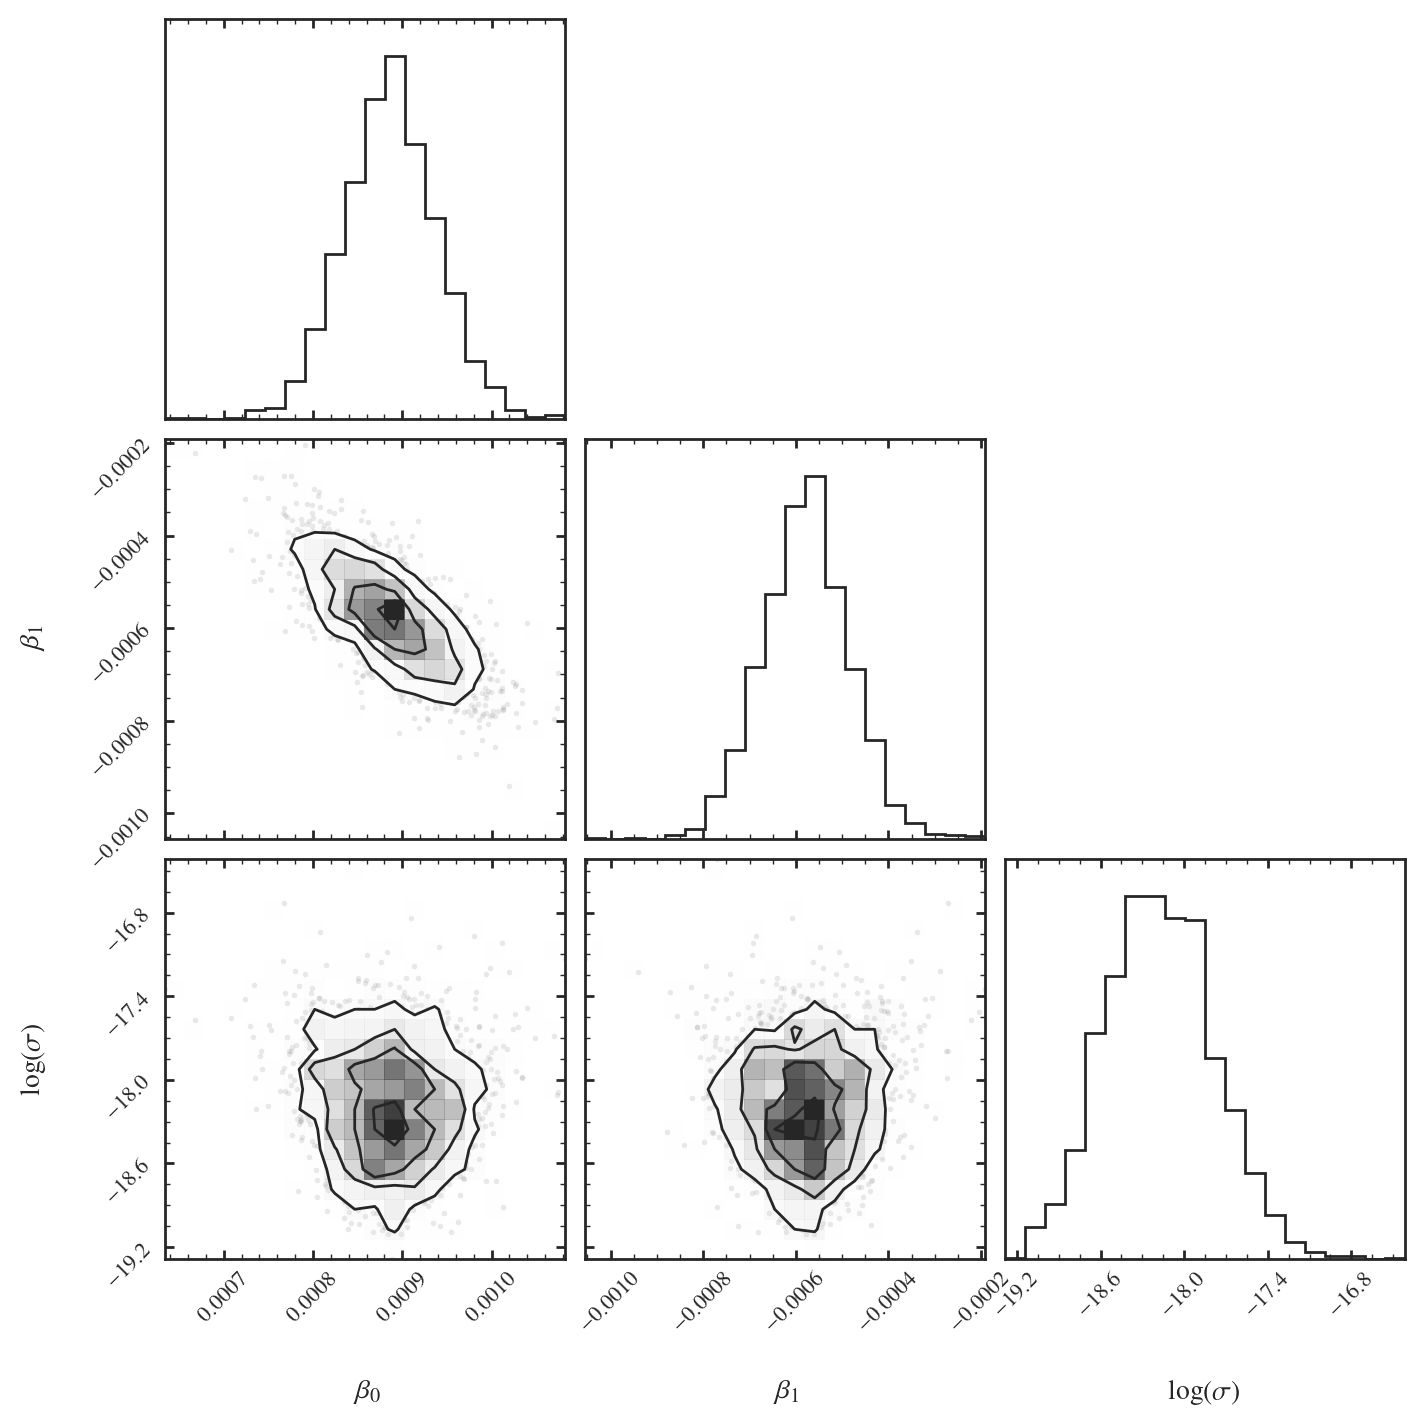

In [53]:
samples = mcmc_utils.run_mcmc(exp_model, obs, N=N, discard=discard)

$\beta_0$ = 8.87e-04 + 5.27e-05 - 5.06e-05
$\beta_1$ = -5.79e-04 + 9.53e-05 - 9.07e-05
$\log(\sigma)$ = -1.82e+01 + 3.83e-01 - 3.99e-01


(-0.001, 0.002)

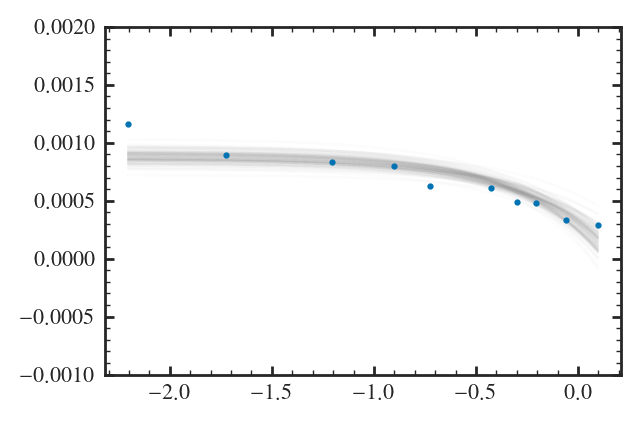

In [54]:
mcmc_utils.plot_posterior(exp_model, obs, samples)
plt.ylim(-1e-3, 2e-3)

# V13

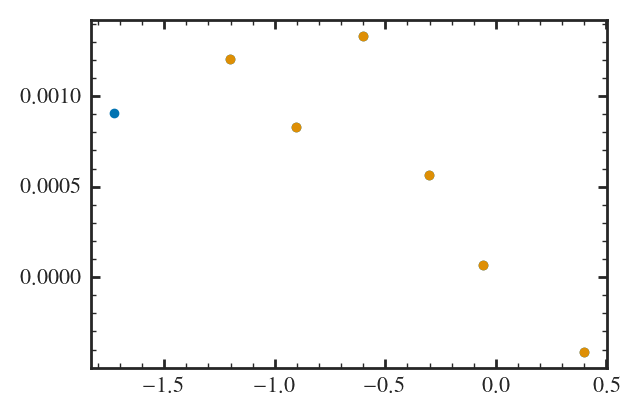

In [55]:
obs = get_yield_table("ventura13")

plt.scatter(obs[0], obs[1])
obs = list(obs)
obs[0] = obs[0][1:]
obs[1] = obs[1][1:]
plt.scatter(obs[0], obs[1])


100%|██████████| 3000/3000 [00:12<00:00, 244.13it/s]


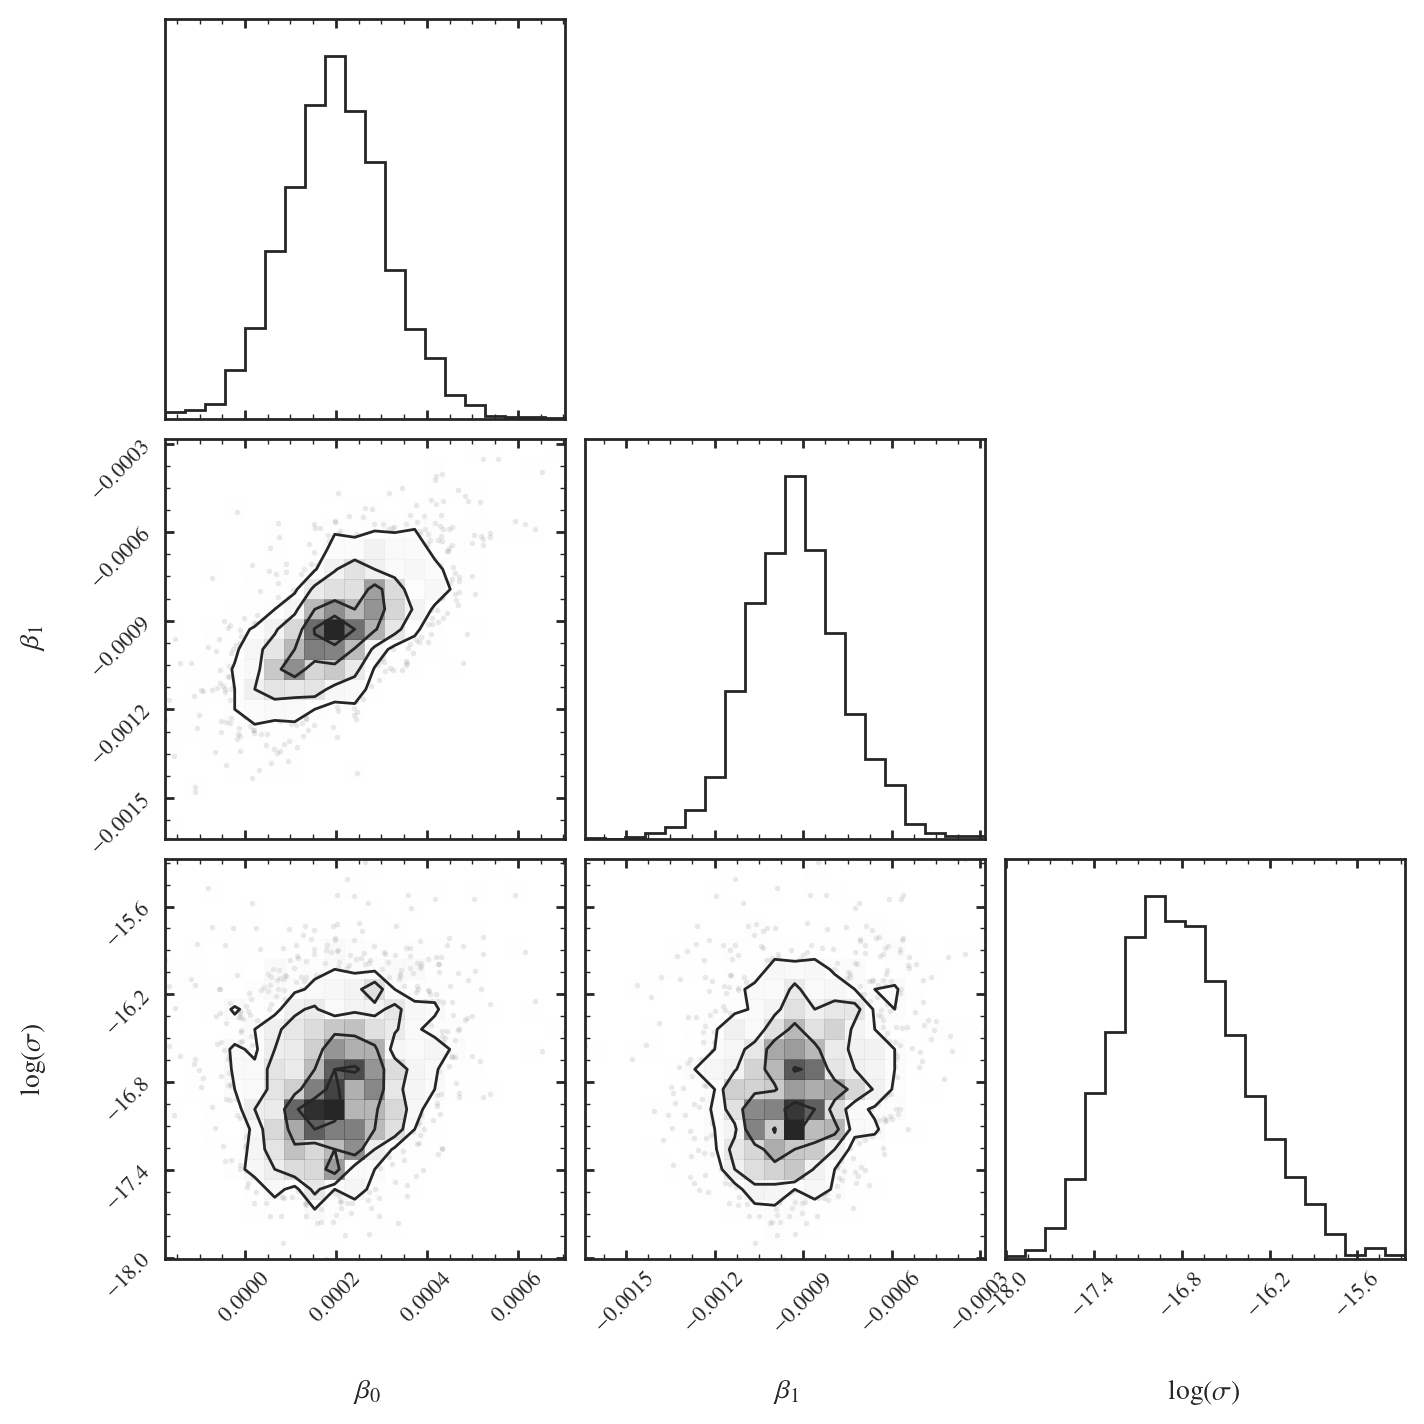

In [56]:
samples = mcmc_utils.run_mcmc(lin_model, obs, N=N, discard=discard)

$\beta_0$ = 2.02e-04 + 1.14e-04 - 1.05e-04
$\beta_1$ = -9.26e-04 + 1.55e-04 - 1.59e-04
$\log(\sigma)$ = -1.68e+01 + 4.00e-01 - 4.66e-01


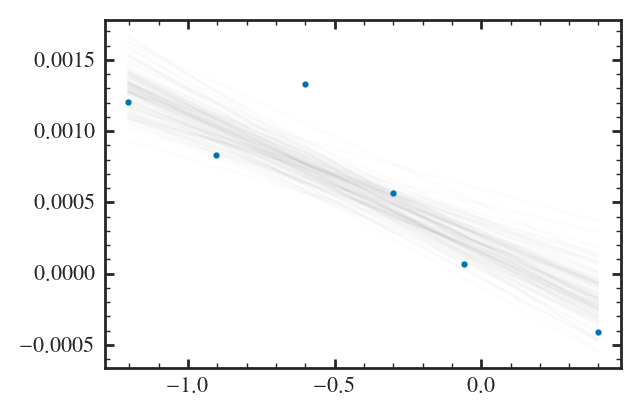

In [57]:
mcmc_utils.plot_posterior(lin_model, obs, samples)

$\beta_0$ = 2.02e-04 + 1.14e-04 - 1.05e-04
$\beta_1$ = -9.26e-04 + 1.55e-04 - 1.59e-04
$\log(\sigma)$ = -1.68e+01 + 4.00e-01 - 4.66e-01


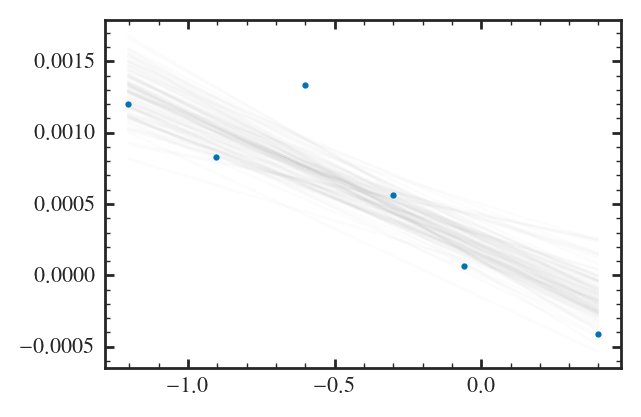

In [58]:
mcmc_utils.plot_posterior(lin_model, obs, samples)

100%|██████████| 3000/3000 [00:15<00:00, 194.88it/s]


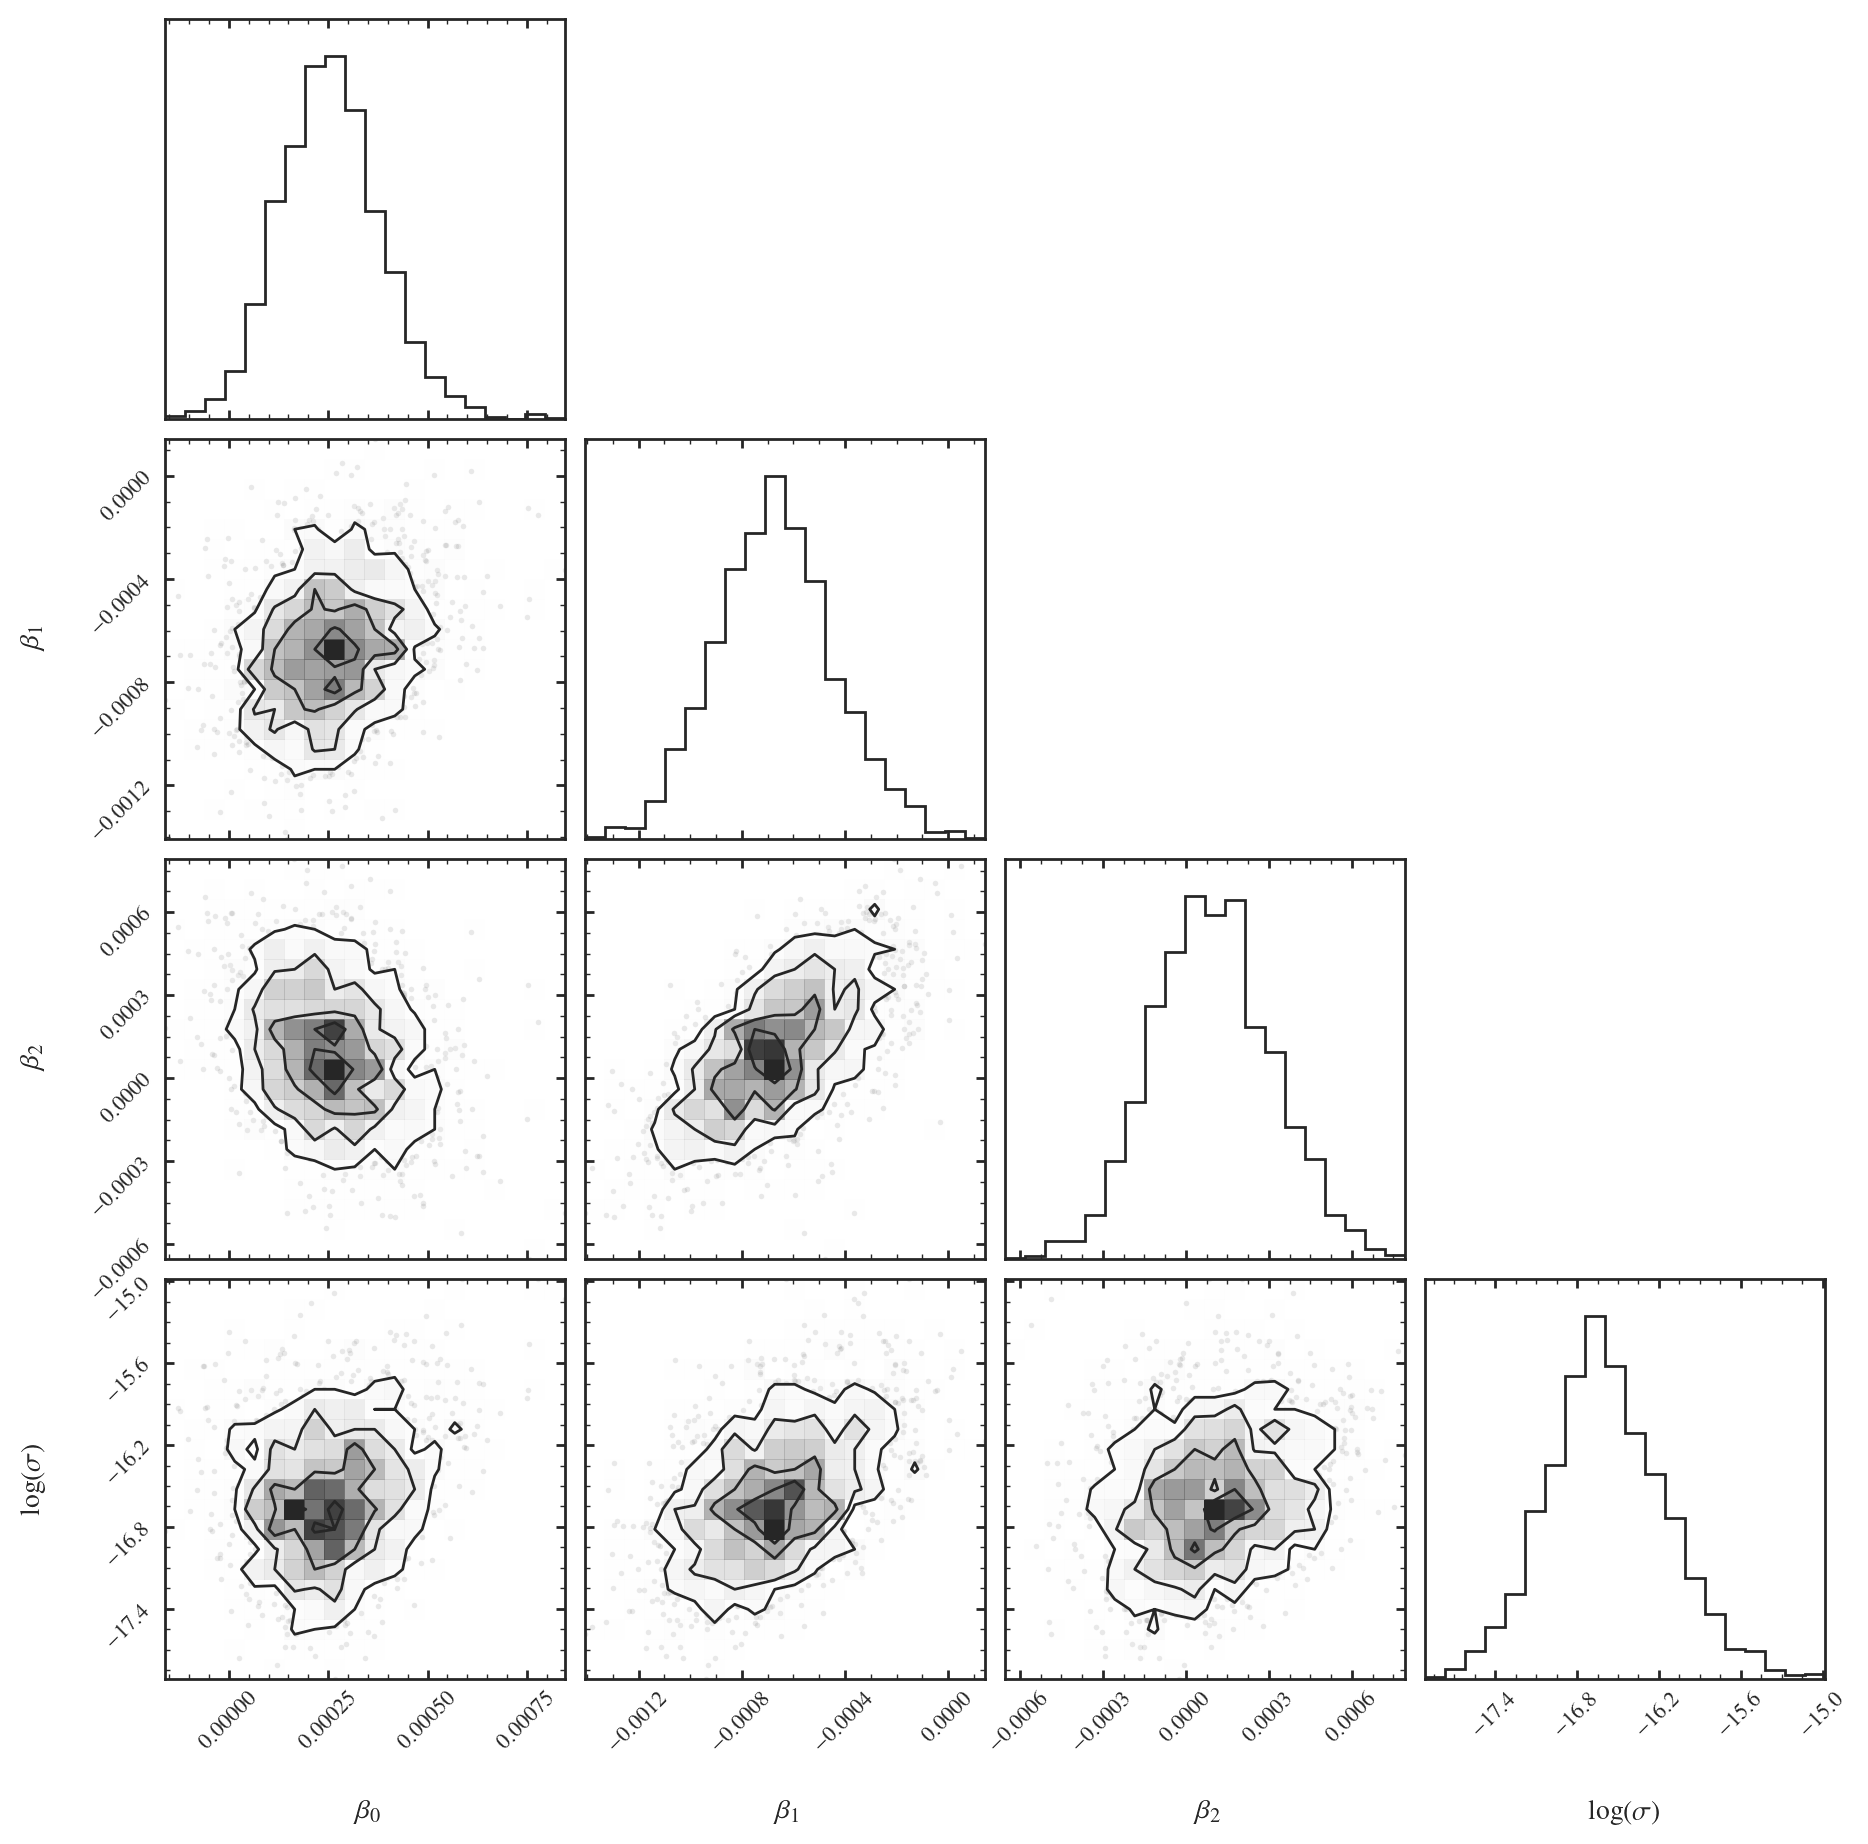

In [59]:
samples = mcmc_utils.run_mcmc(quad_model, obs, N=N, discard=discard)

$\beta_0$ = 2.53e-04 + 1.23e-04 - 1.28e-04
$\beta_1$ = -6.77e-04 + 2.22e-04 - 2.30e-04
$\beta_2$ = 8.63e-05 + 2.05e-04 - 2.27e-04
$\log(\sigma)$ = -1.66e+01 + 3.98e-01 - 4.69e-01


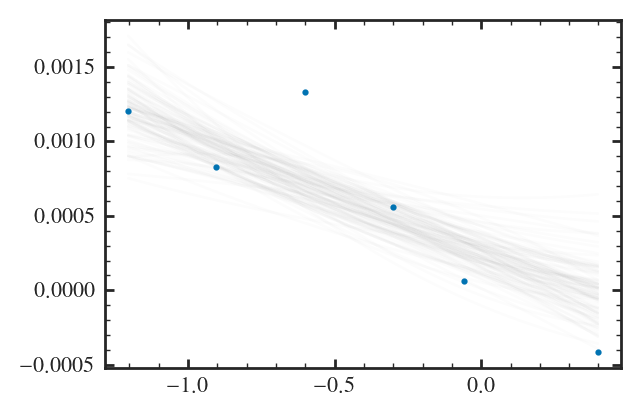

In [60]:
mcmc_utils.plot_posterior(quad_model, obs, samples)

100%|██████████| 3000/3000 [00:12<00:00, 249.81it/s]


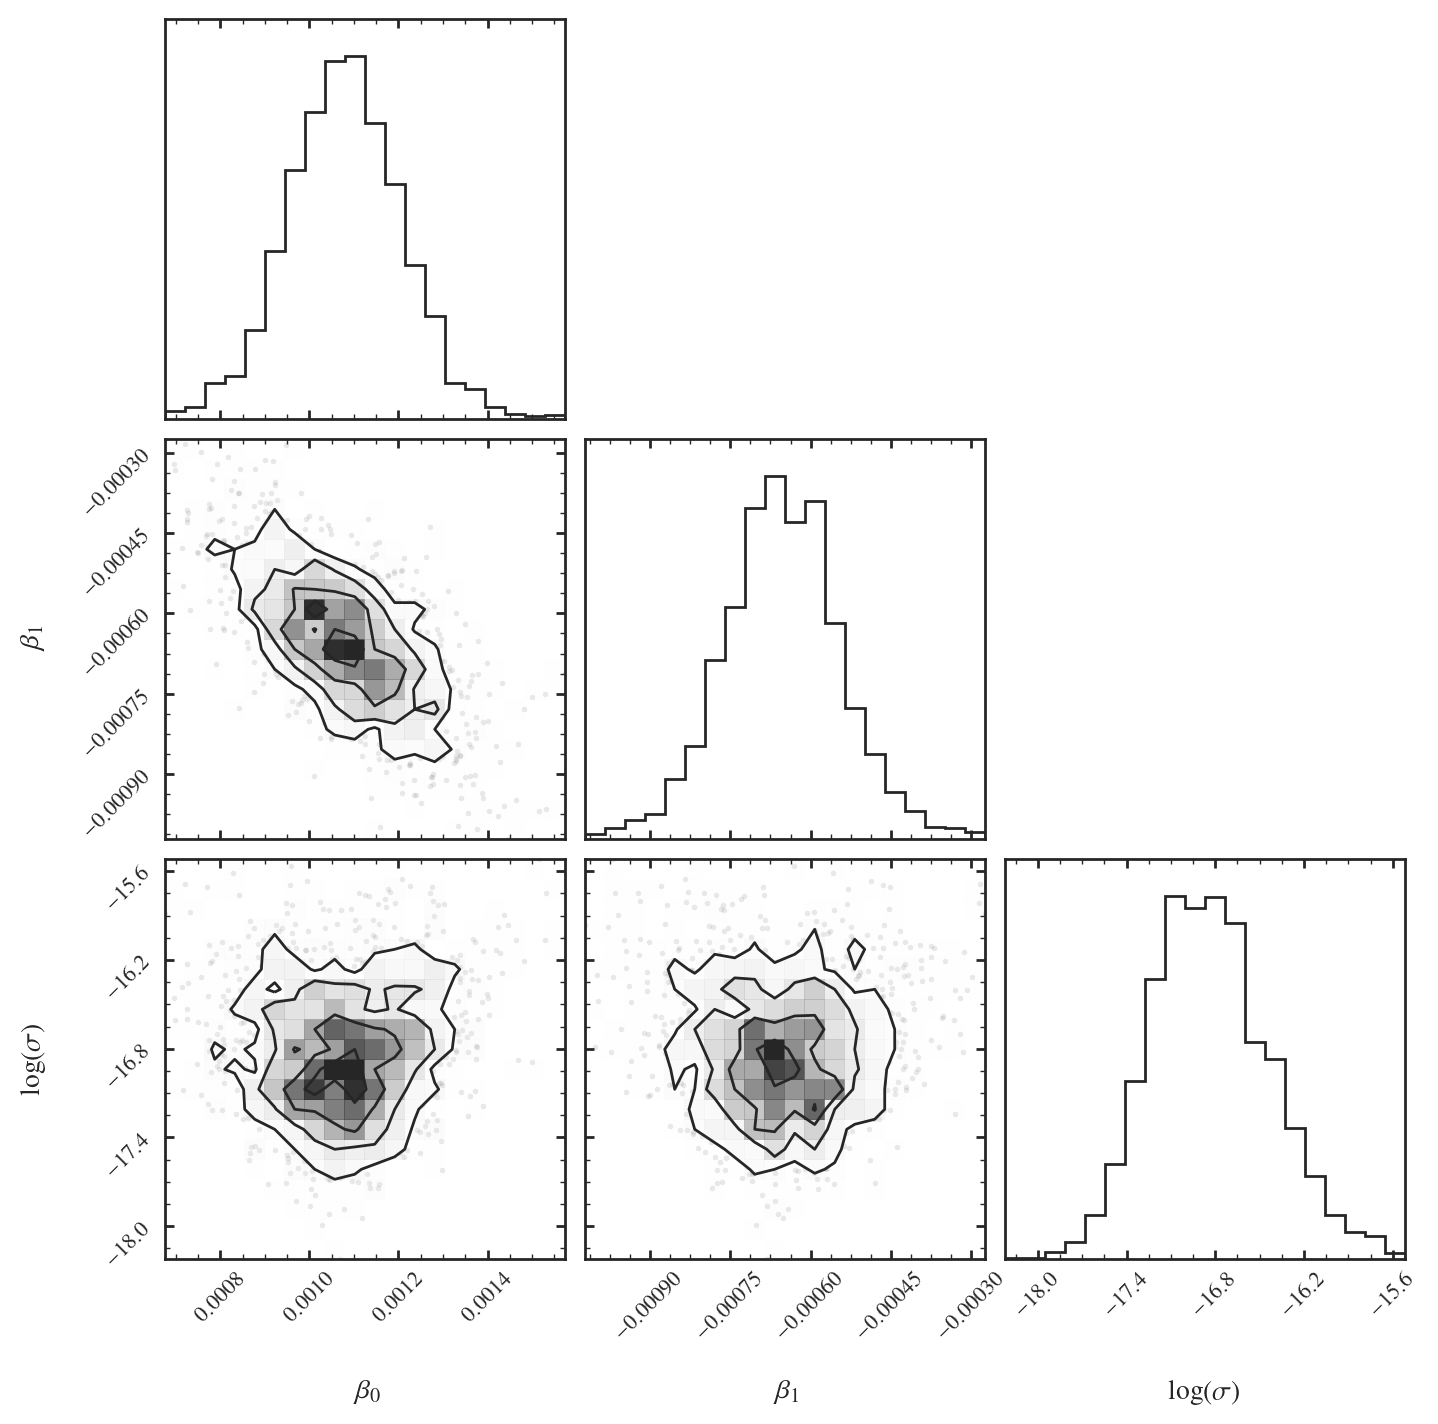

In [61]:
samples = mcmc_utils.run_mcmc(exp_model, obs, N=N, discard=discard)

$\beta_0$ = 1.08e-03 + 1.26e-04 - 1.27e-04
$\beta_1$ = -6.55e-04 + 1.03e-04 - 1.00e-04
$\log(\sigma)$ = -1.69e+01 + 3.76e-01 - 4.32e-01


(-0.001, 0.002)

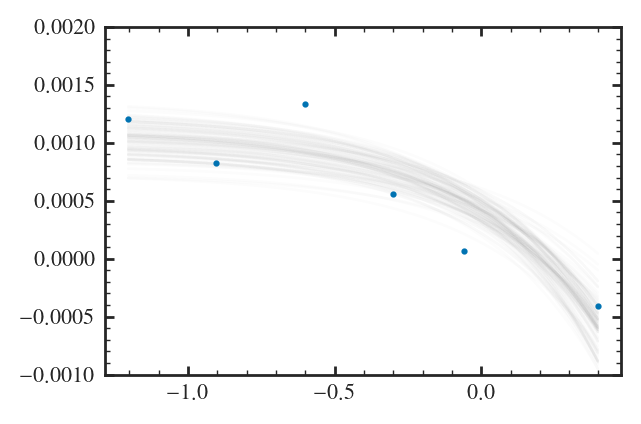

In [62]:
mcmc_utils.plot_posterior(exp_model, obs, samples)
plt.ylim(-1e-3, 2e-3)

# K16

In [63]:
obs = get_yield_table("karakas16")

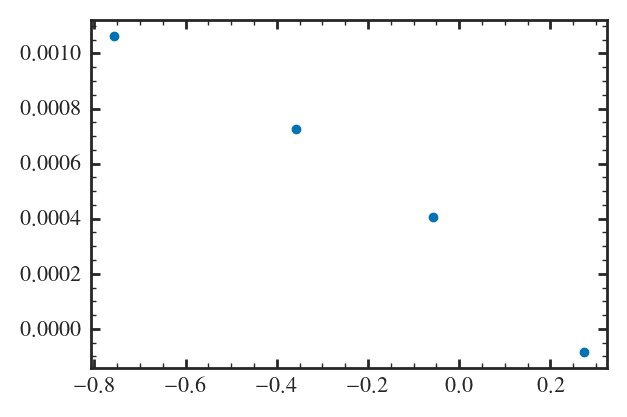

In [64]:
plt.scatter(obs[0], obs[1])

100%|██████████| 3000/3000 [00:11<00:00, 255.37it/s]


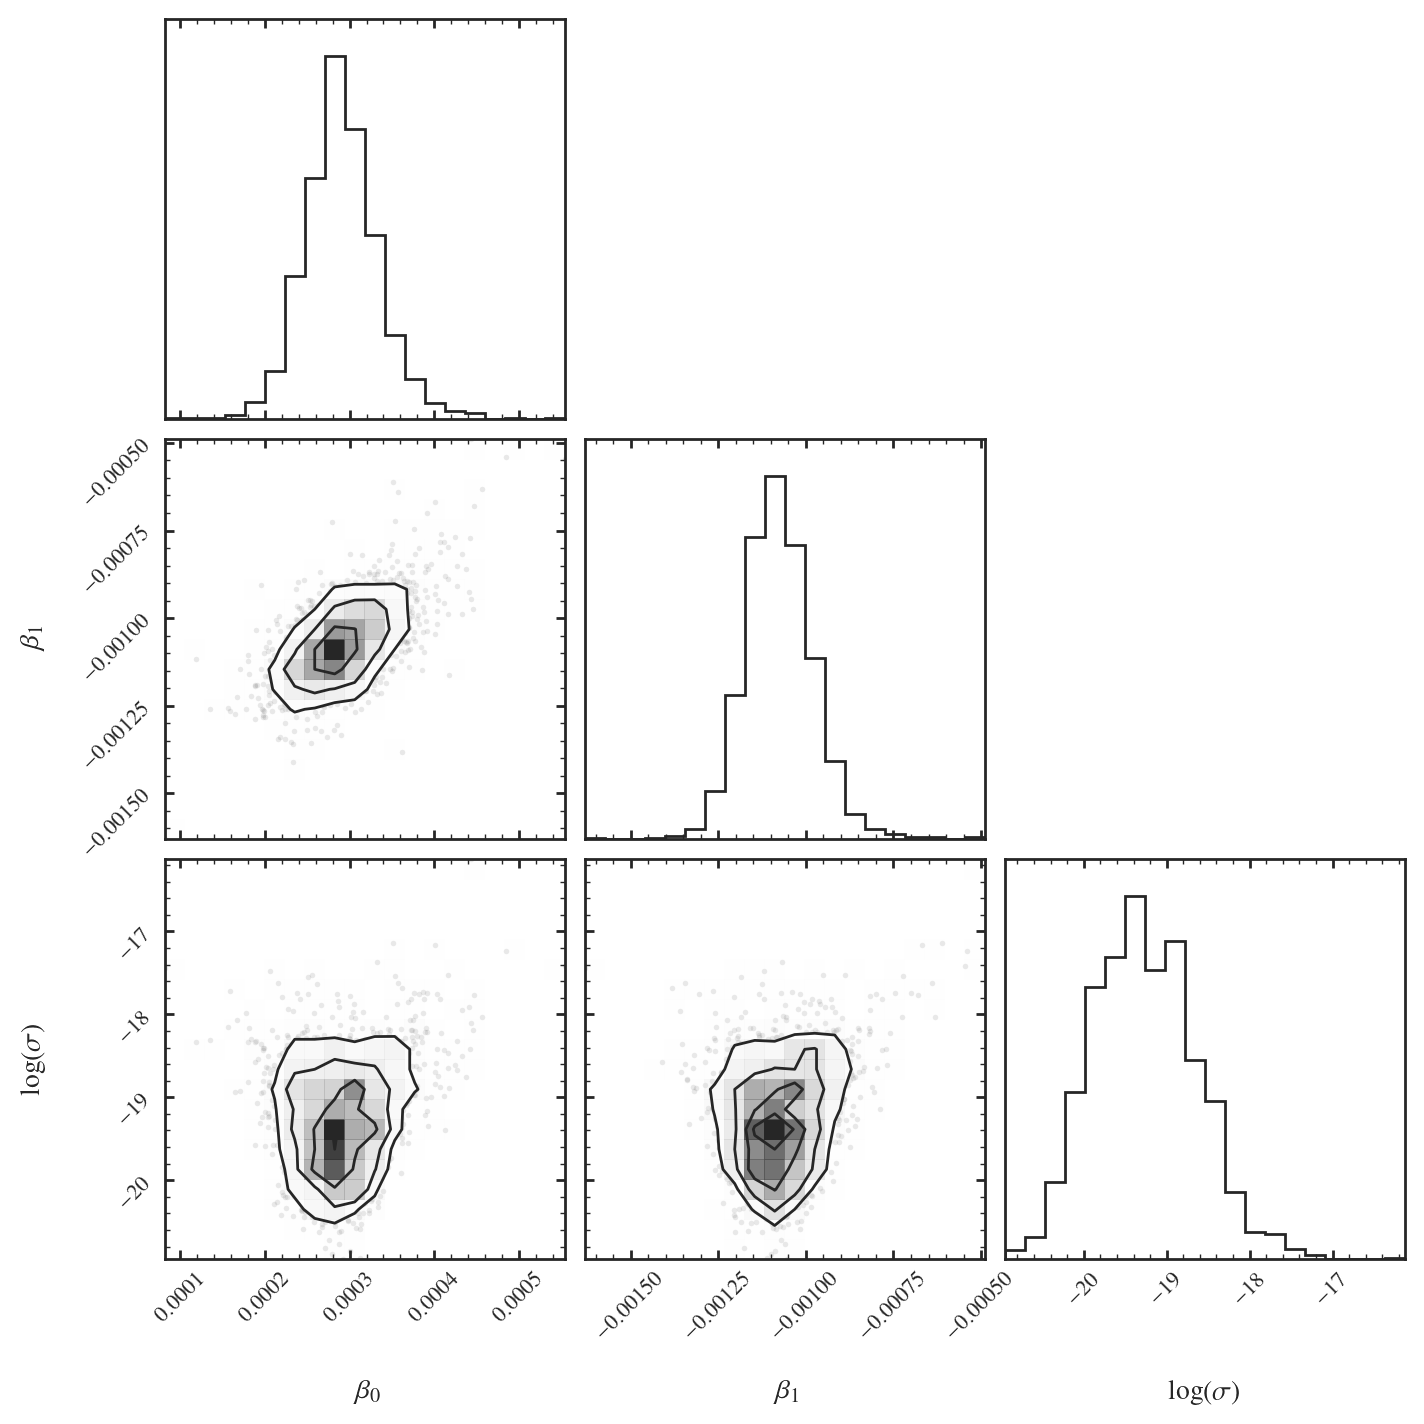

In [65]:
samples = mcmc_utils.run_mcmc(lin_model, obs, N=N, discard=discard)

$\beta_0$ = 2.89e-04 + 3.90e-05 - 4.24e-05
$\beta_1$ = -1.08e-03 + 8.53e-05 - 9.81e-05
$\log(\sigma)$ = -1.93e+01 + 6.09e-01 - 6.59e-01


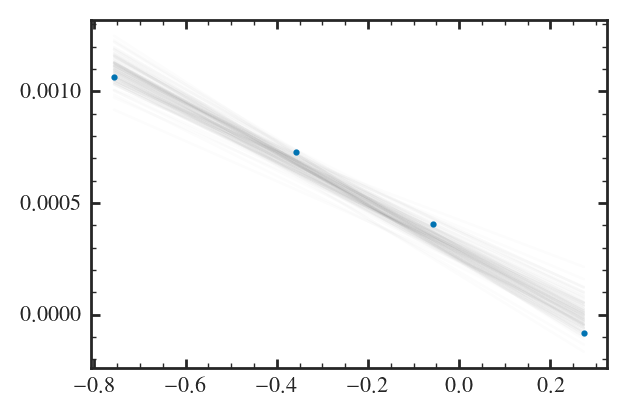

In [66]:
mcmc_utils.plot_posterior(lin_model, obs, samples)

100%|██████████| 3000/3000 [00:15<00:00, 195.53it/s]


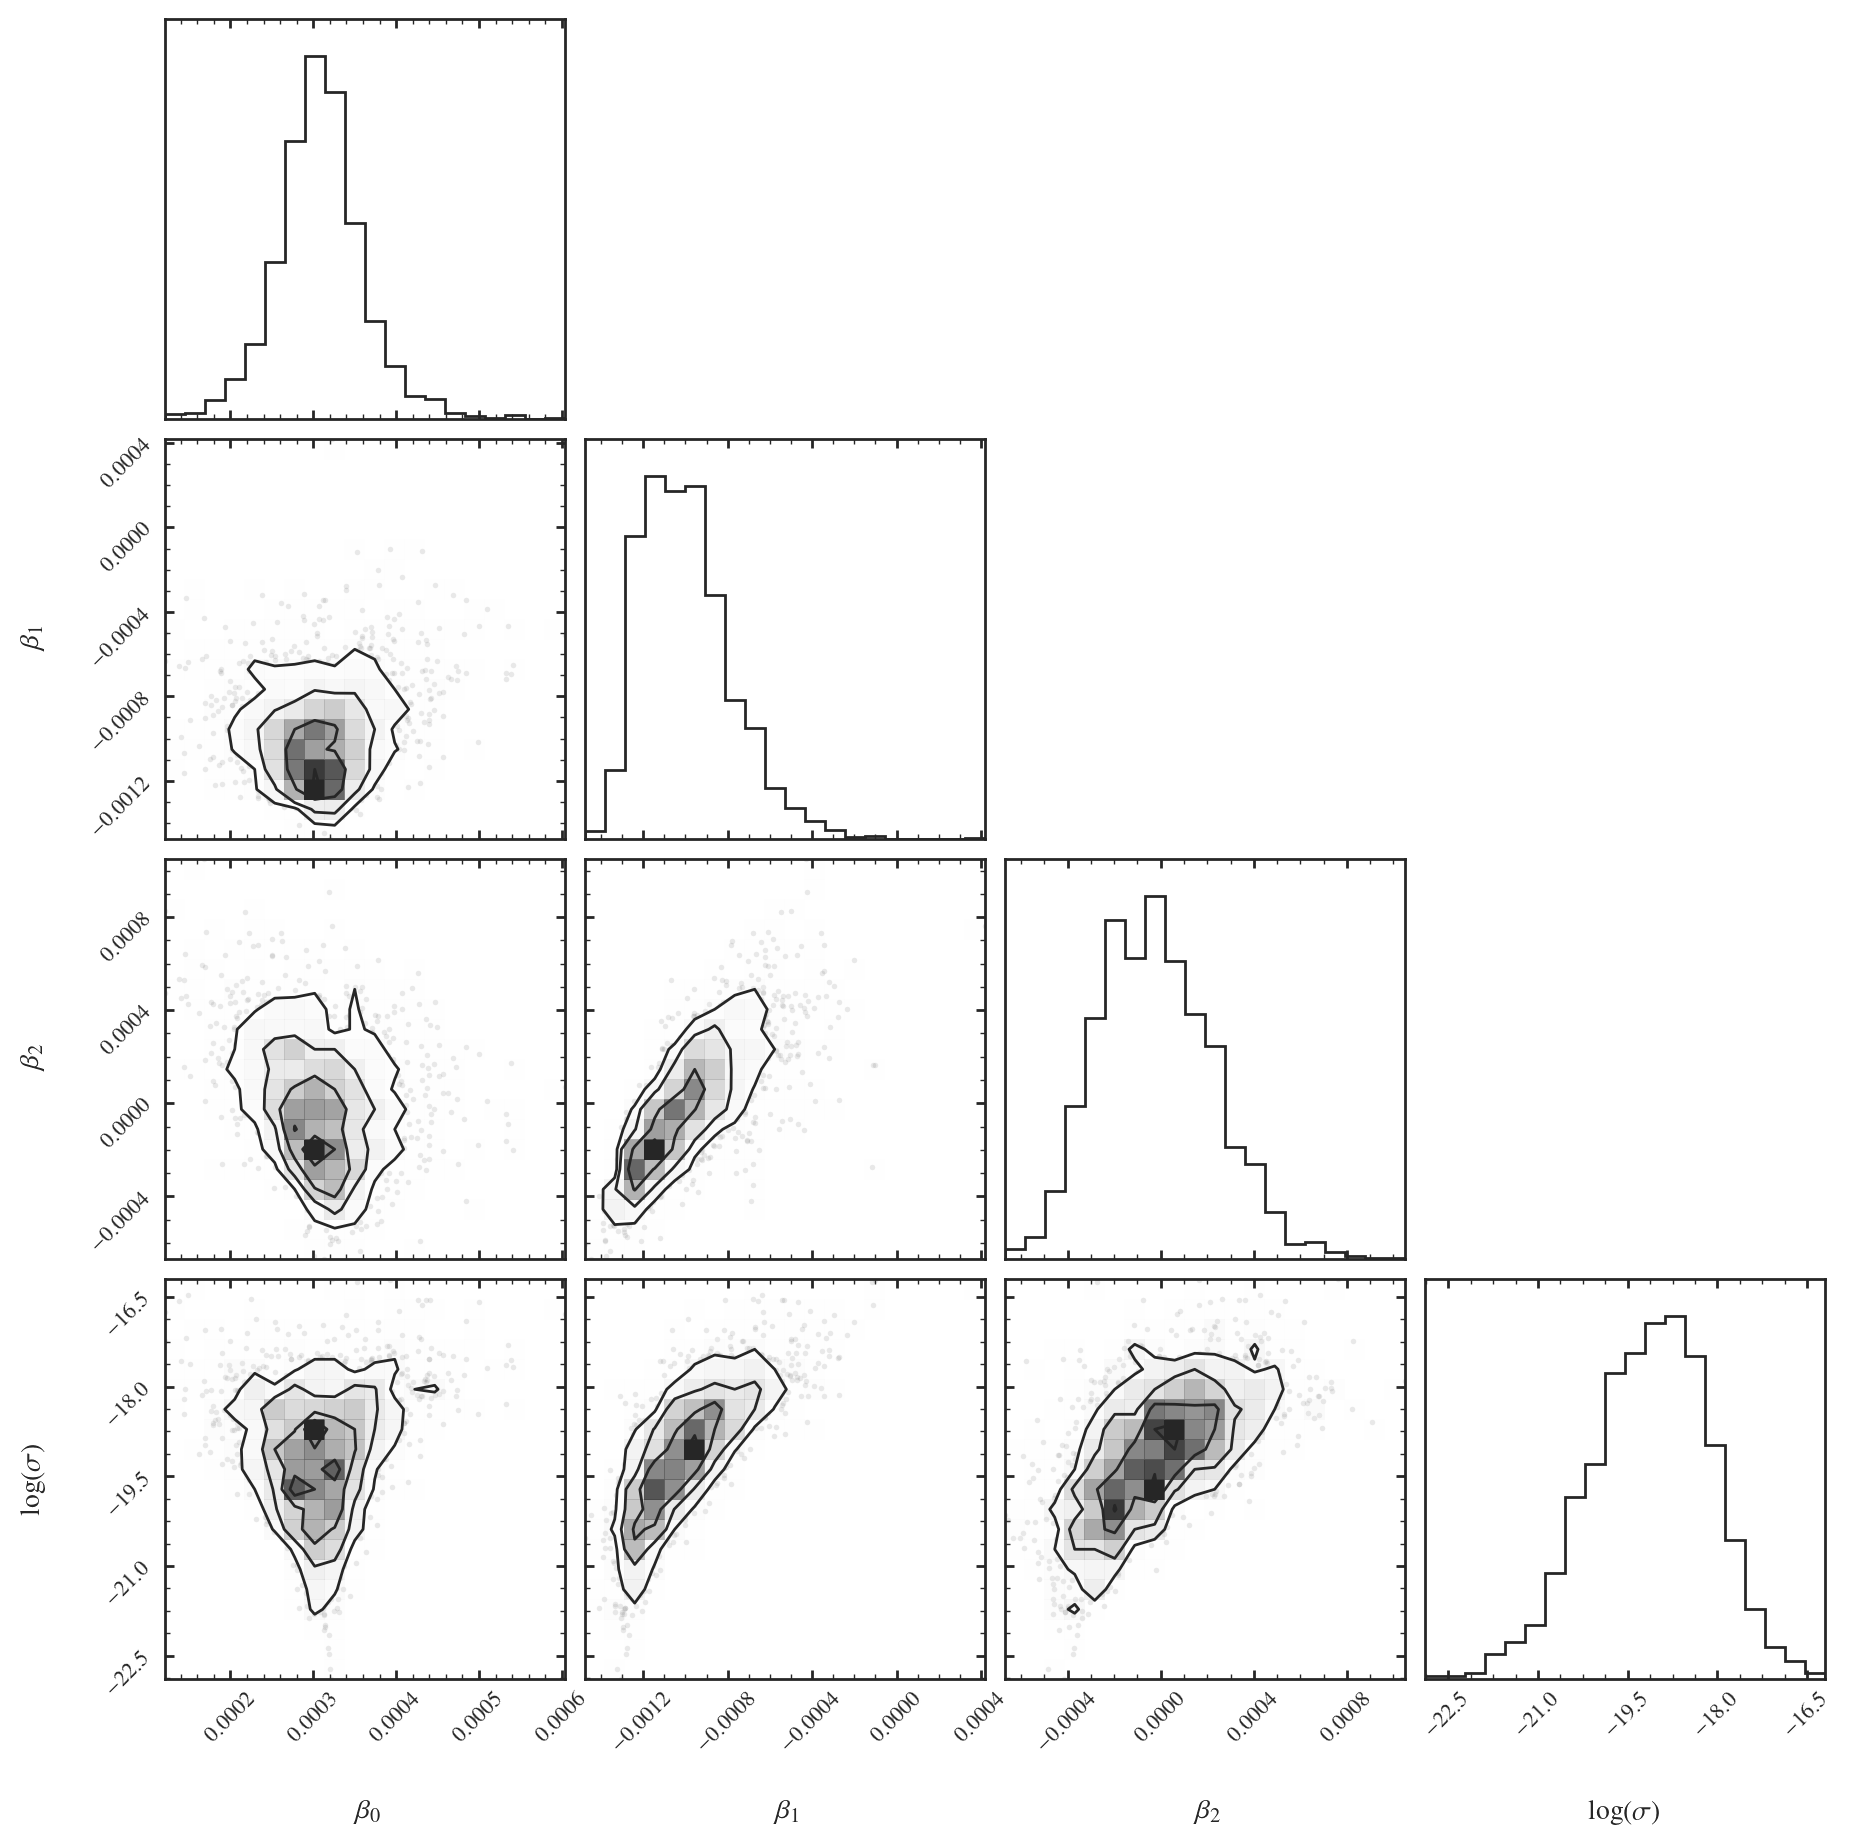

In [67]:
samples = mcmc_utils.run_mcmc(quad_model, obs, N=N, discard=discard)

$\beta_0$ = 3.07e-04 + 4.66e-05 - 4.78e-05
$\beta_1$ = -1.03e-03 + 1.82e-04 - 2.34e-04
$\beta_2$ = -4.03e-05 + 2.27e-04 - 2.67e-04
$\log(\sigma)$ = -1.91e+01 + 1.11e+00 - 9.34e-01


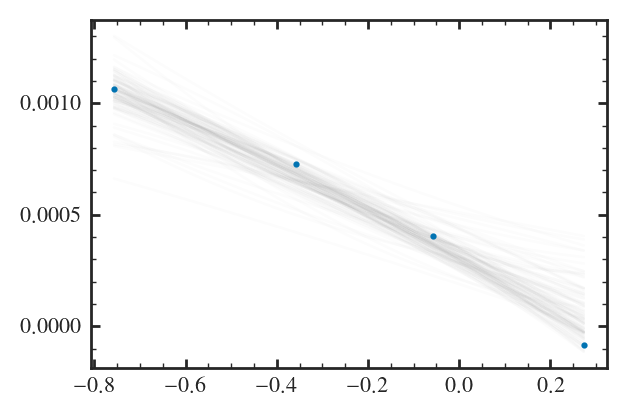

In [68]:
mcmc_utils.plot_posterior(quad_model, obs, samples)

100%|██████████| 3000/3000 [00:12<00:00, 244.27it/s]


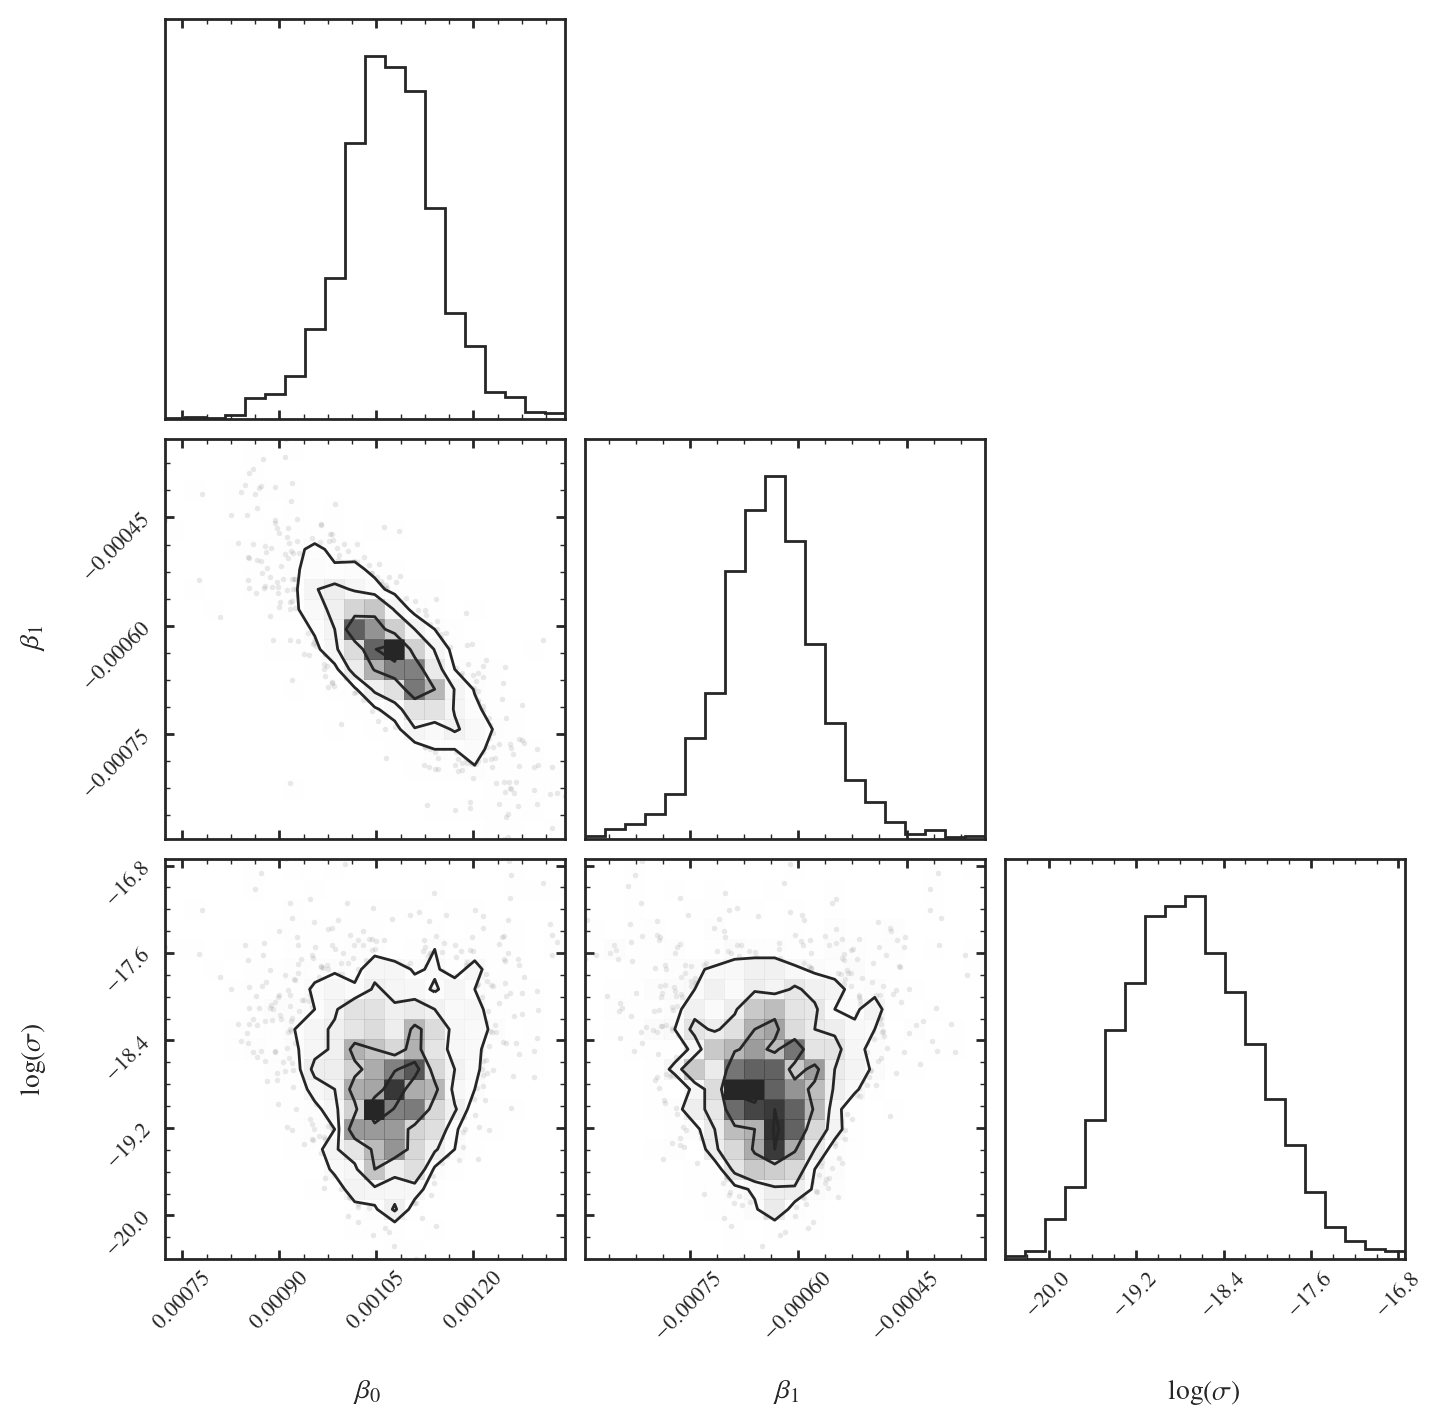

In [69]:
samples = mcmc_utils.run_mcmc(exp_model, obs, N=N, discard=discard)

$\beta_0$ = 1.07e-03 + 6.64e-05 - 6.96e-05
$\beta_1$ = -6.41e-04 + 6.28e-05 - 6.30e-05
$\log(\sigma)$ = -1.87e+01 + 5.72e-01 - 6.35e-01


(-0.001, 0.002)

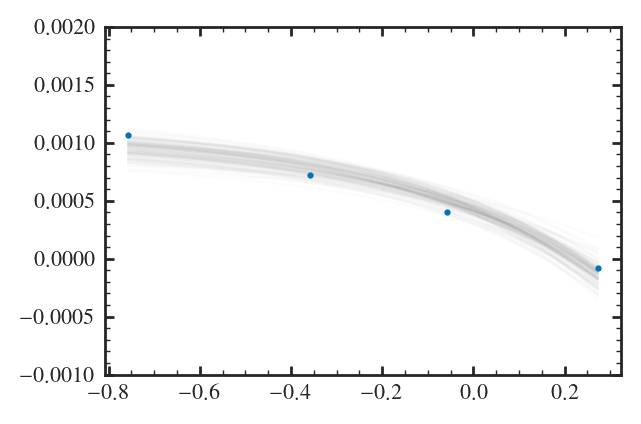

In [70]:
mcmc_utils.plot_posterior(exp_model, obs, samples)
plt.ylim(-1e-3, 2e-3)

# P16

In [71]:
obs = get_yield_table("pignatari16")

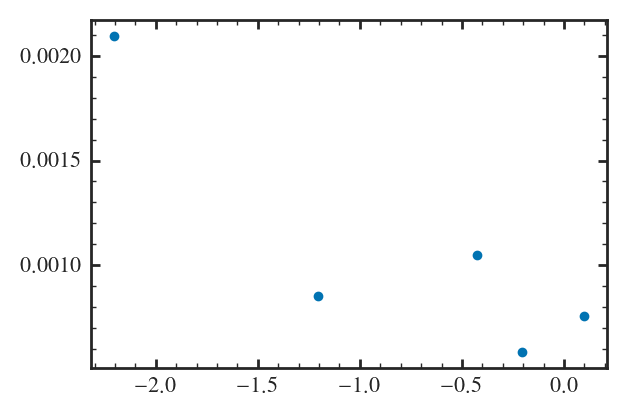

In [72]:
plt.scatter(obs[0], obs[1])

100%|██████████| 3000/3000 [00:11<00:00, 265.76it/s]


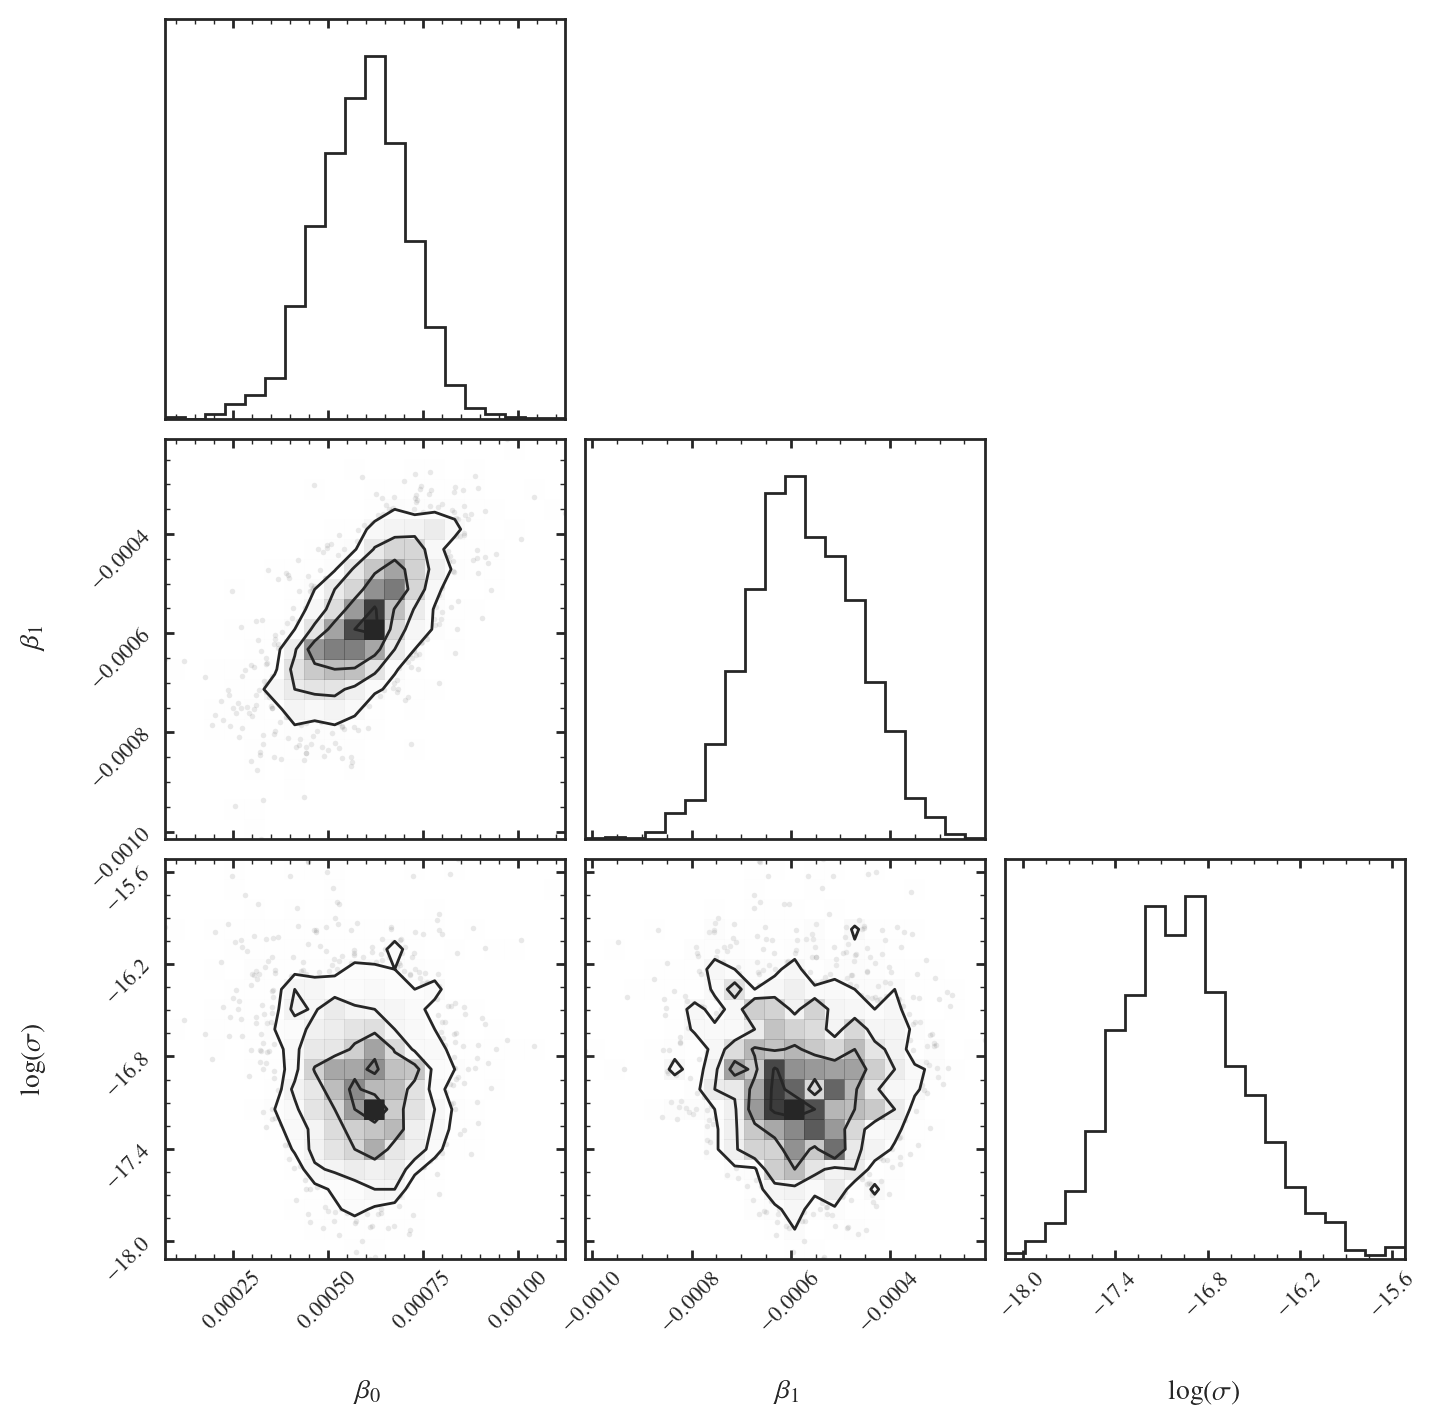

In [73]:
samples = mcmc_utils.run_mcmc(lin_model, obs, N=N, discard=discard)

$\beta_0$ = 5.96e-04 + 1.26e-04 - 1.09e-04
$\beta_1$ = -5.79e-04 + 1.03e-04 - 1.15e-04
$\log(\sigma)$ = -1.70e+01 + 3.81e-01 - 4.46e-01


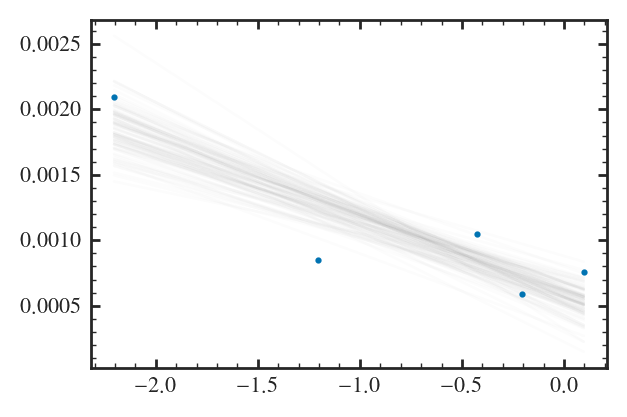

In [74]:
mcmc_utils.plot_posterior(lin_model, obs, samples)

100%|██████████| 3000/3000 [00:15<00:00, 196.71it/s]


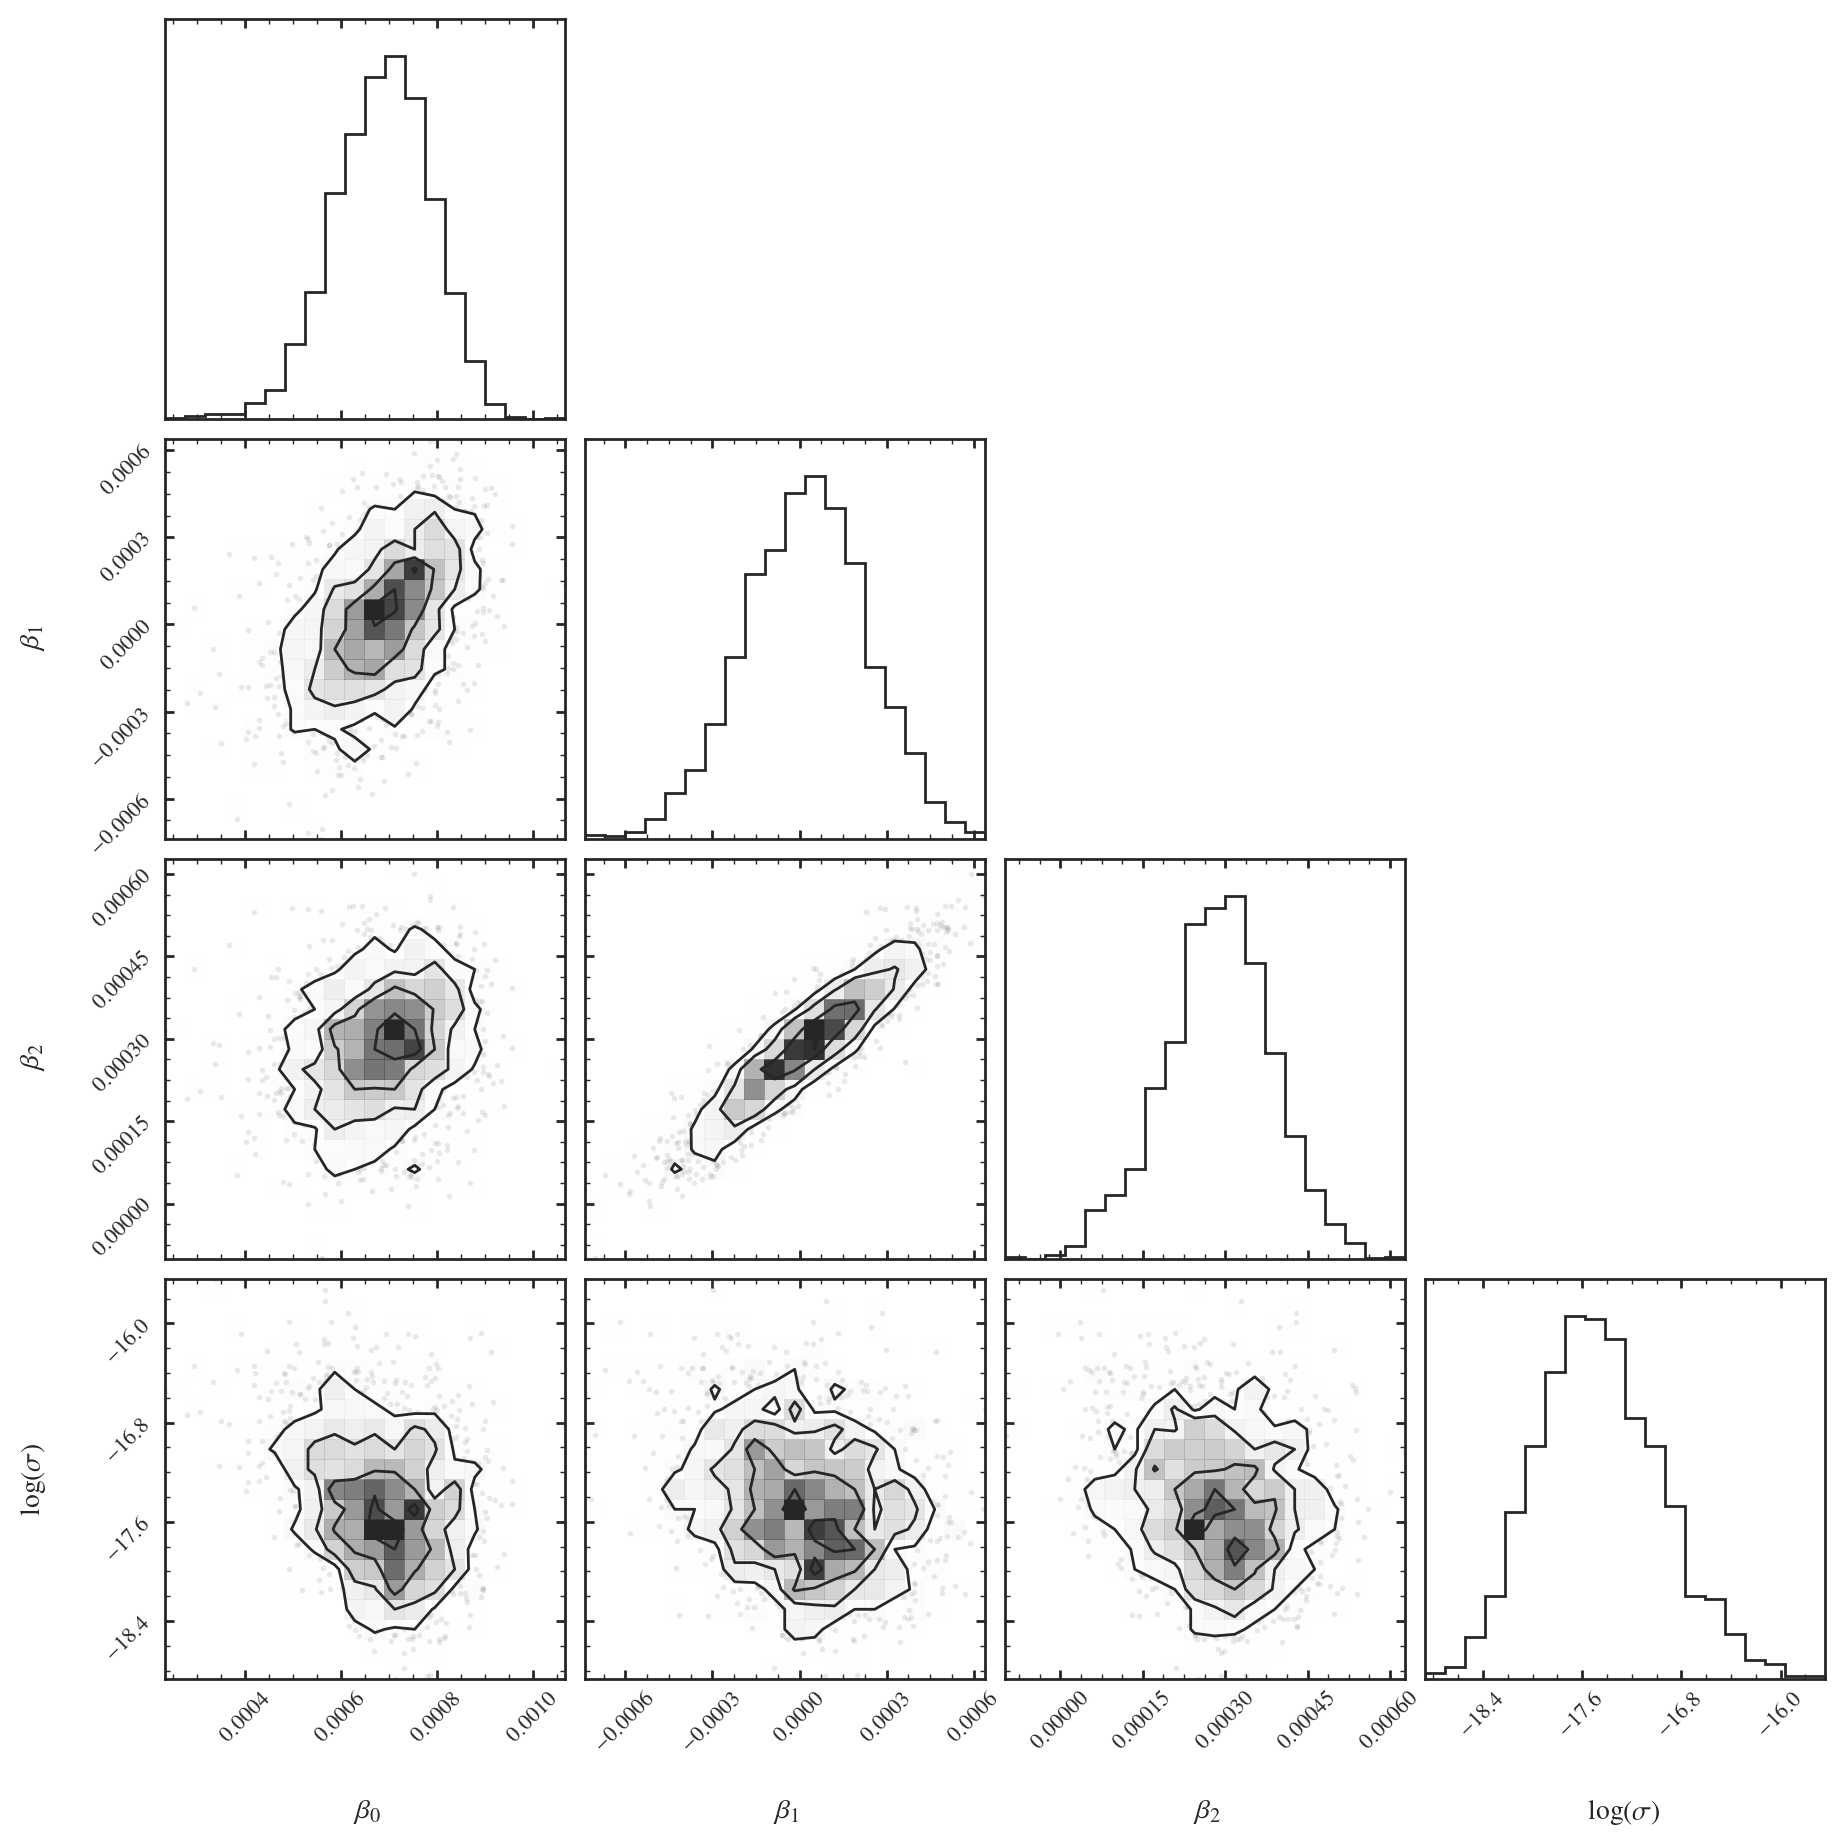

In [75]:
samples = mcmc_utils.run_mcmc(quad_model, obs, N=N, discard=discard)

$\beta_0$ = 6.91e-04 + 1.07e-04 - 9.73e-05
$\beta_1$ = 2.40e-05 + 2.14e-04 - 2.02e-04
$\beta_2$ = 2.89e-04 + 1.01e-04 - 9.35e-05
$\log(\sigma)$ = -1.75e+01 + 4.85e-01 - 5.27e-01


(-0.0003, 0.003)

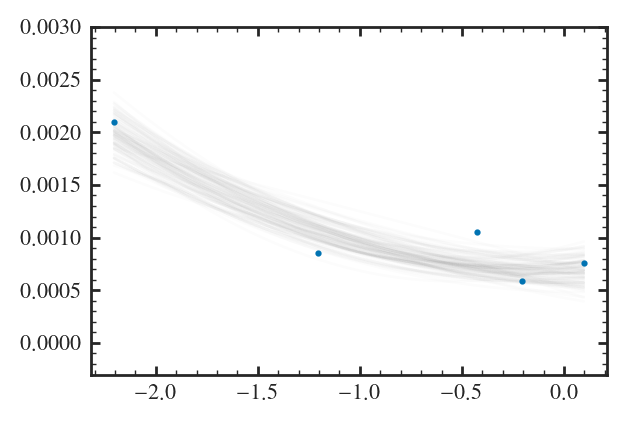

In [76]:
mcmc_utils.plot_posterior(quad_model, obs, samples)
plt.ylim(-0.3e-3, 3e-3)

100%|██████████| 3000/3000 [00:12<00:00, 249.42it/s]


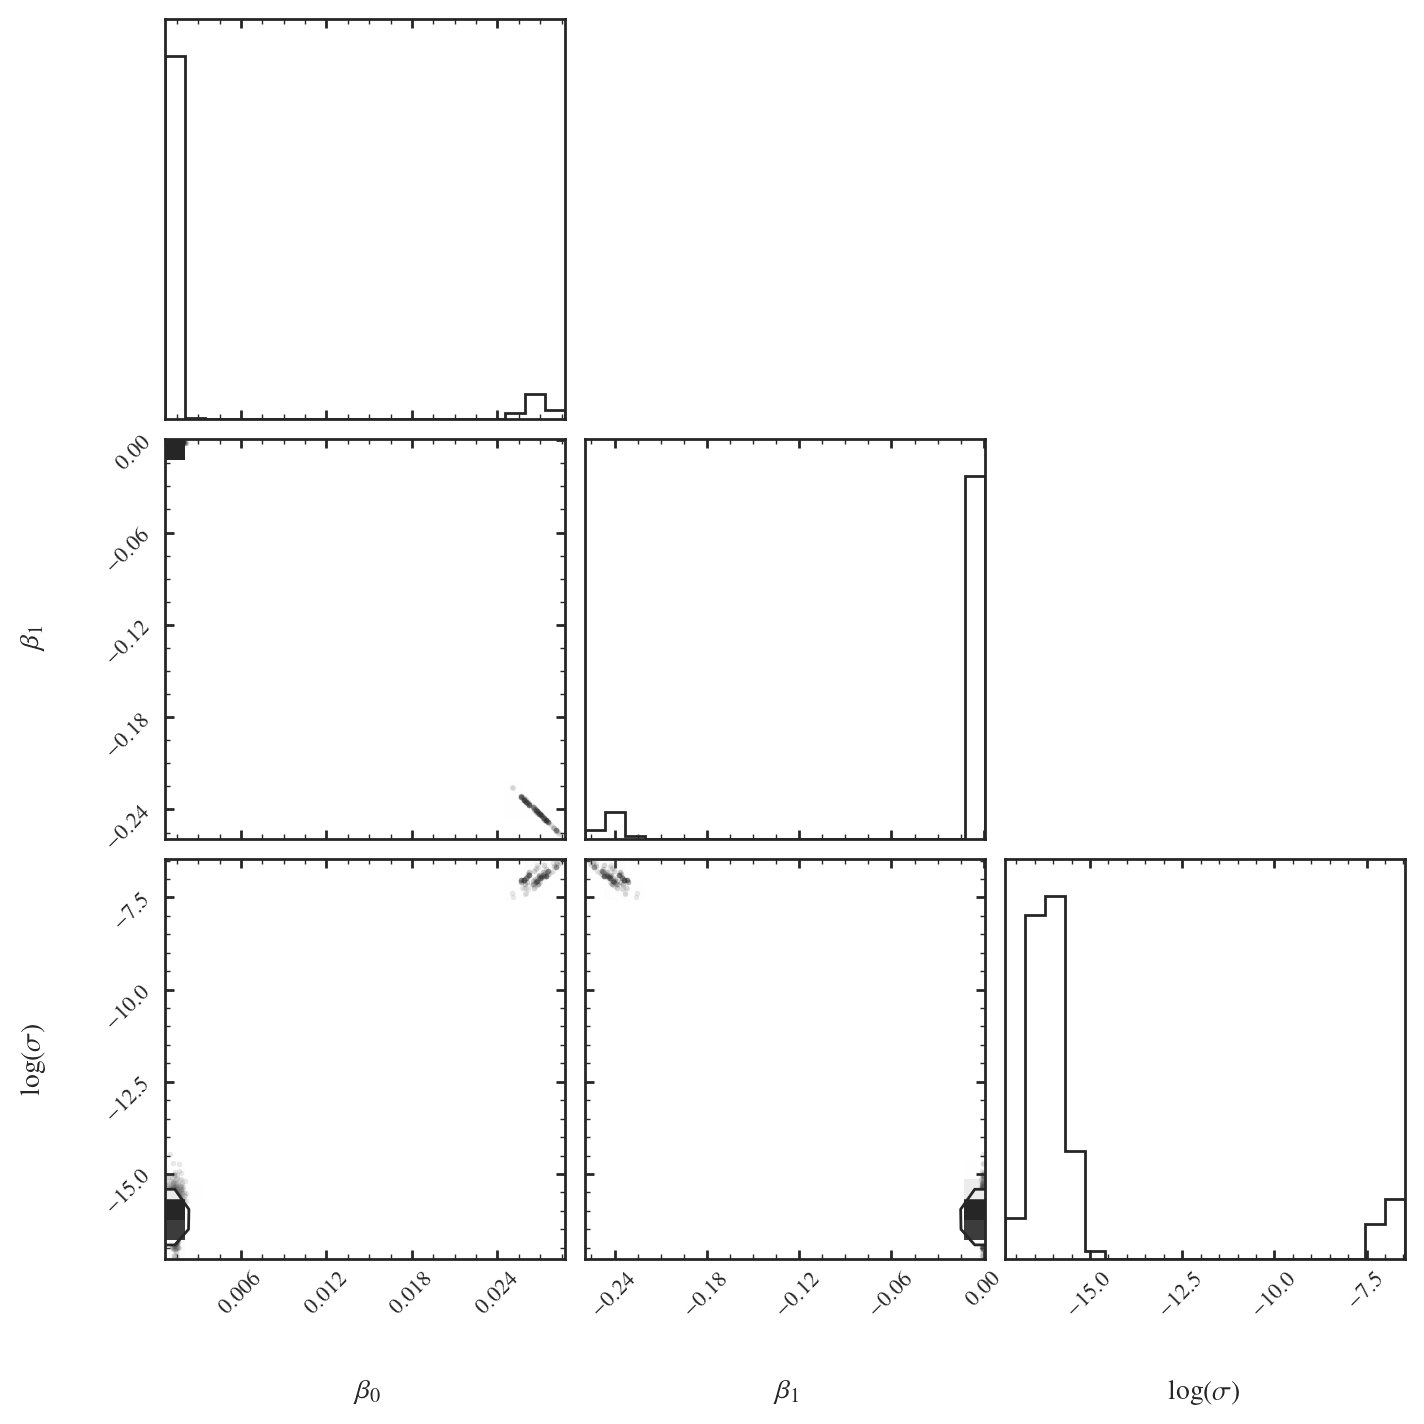

In [77]:
samples = mcmc_utils.run_mcmc(exp_model, obs, N=N, discard=discard)

$\beta_0$ = 1.42e-03 + 2.20e-04 - 2.70e-04
$\beta_1$ = -7.39e-04 + 4.27e-04 - 3.43e-04
$\log(\sigma)$ = -1.61e+01 + 4.22e-01 - 6.17e-01


(-0.0003, 0.003)

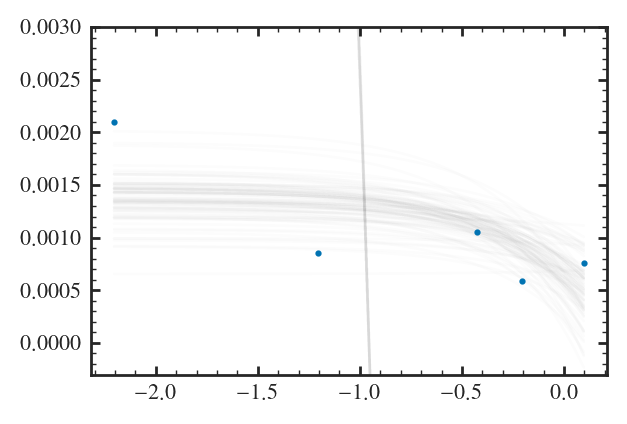

In [78]:
mcmc_utils.plot_posterior(exp_model, obs, samples)
plt.ylim(-0.3e-3, 3e-3)

In [79]:
obs = get_yield_table("pignatari16")
#obs = (obs[0][1:], obs[1][1:], None, None)

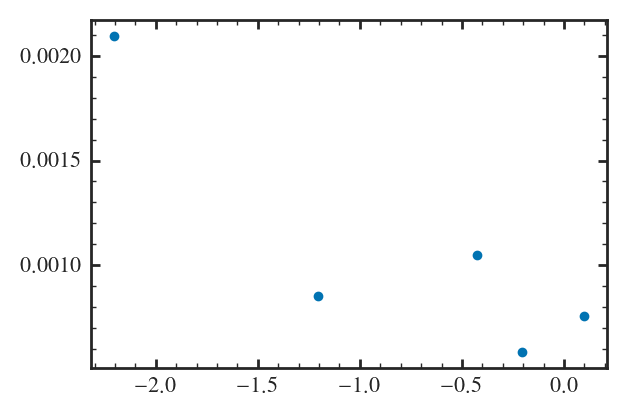

In [80]:
plt.scatter(obs[0], obs[1])

100%|██████████| 3000/3000 [00:11<00:00, 268.85it/s]


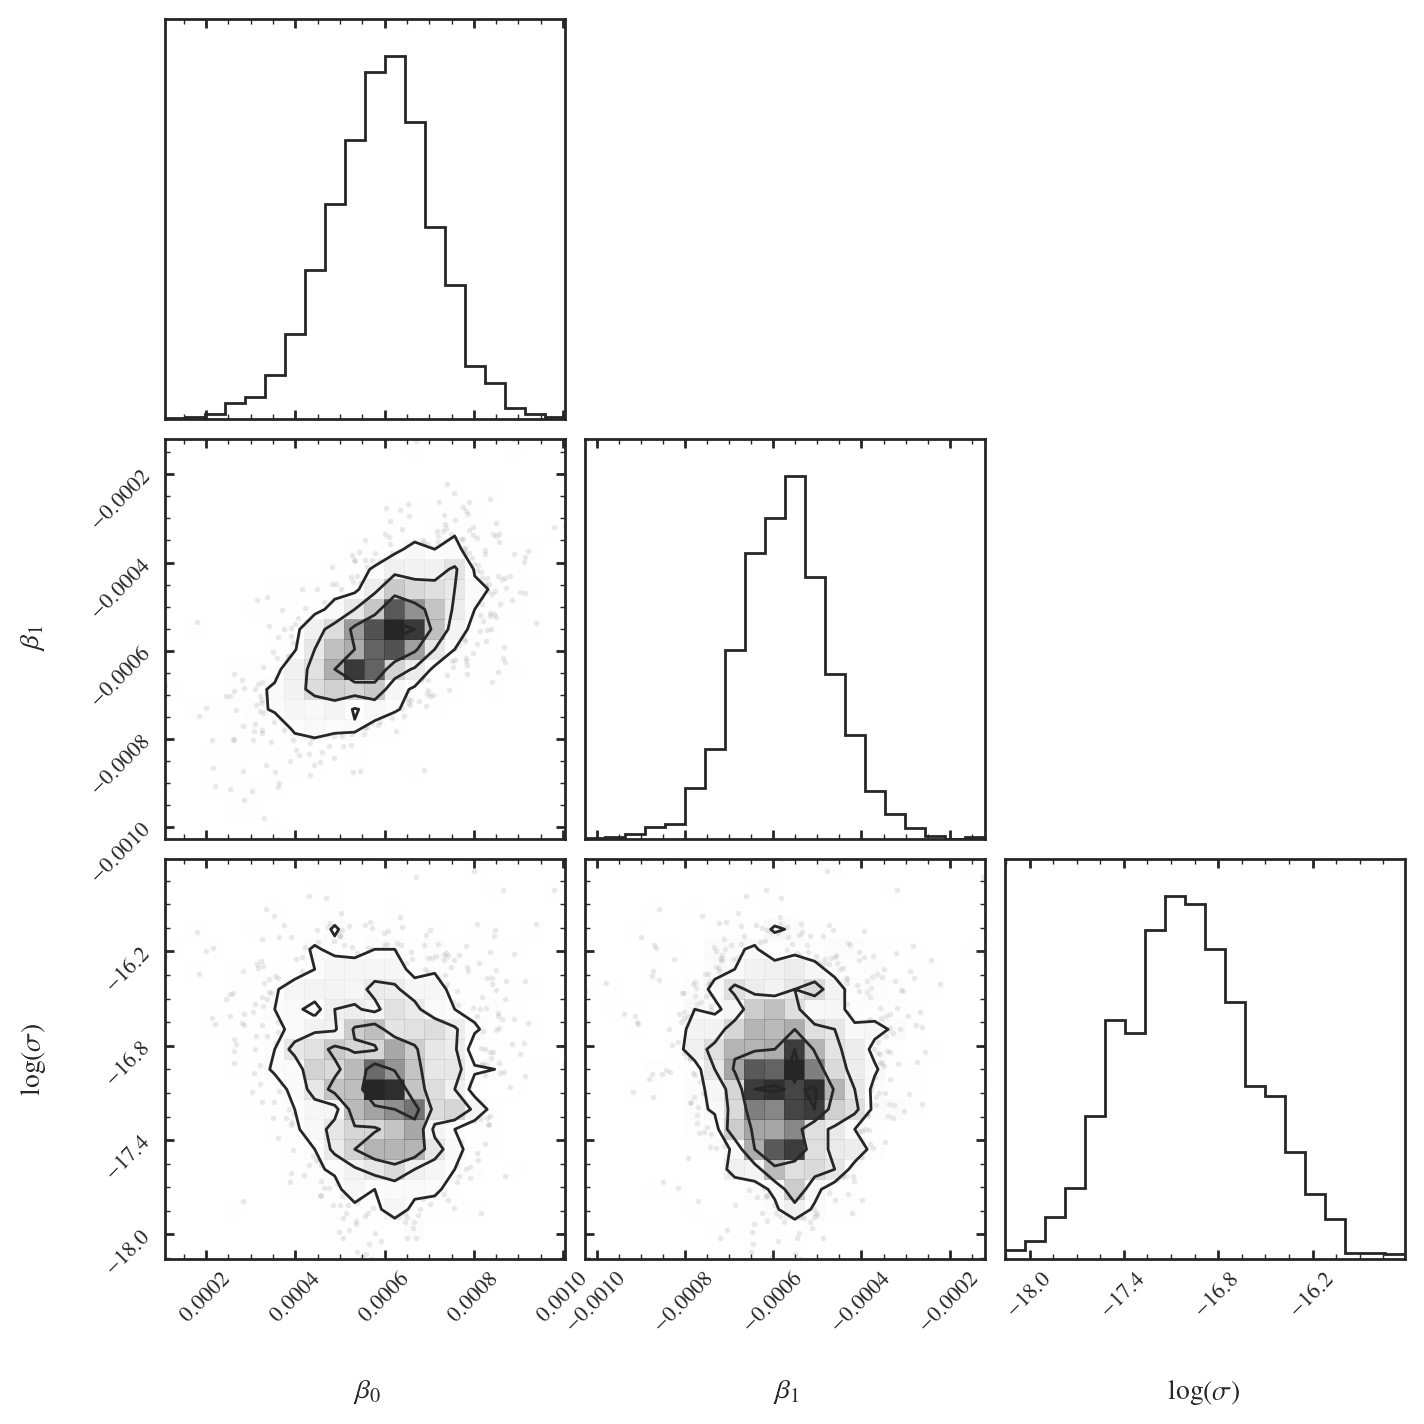

In [81]:
samples = mcmc_utils.run_mcmc(lin_model, obs, N=N, discard=discard)

$\beta_0$ = 5.98e-04 + 1.22e-04 - 1.08e-04
$\beta_1$ = -5.73e-04 + 1.03e-04 - 9.98e-05
$\log(\sigma)$ = -1.70e+01 + 4.15e-01 - 4.40e-01


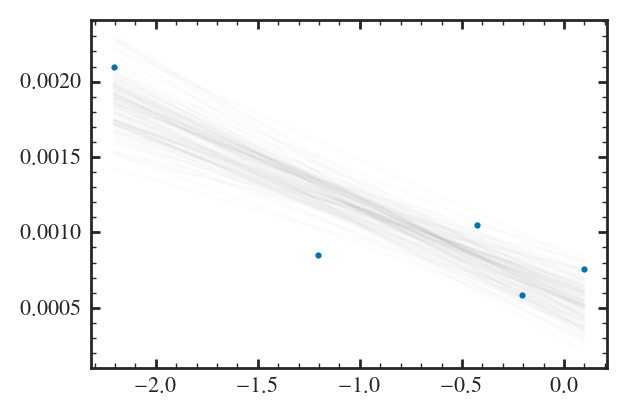

In [82]:
mcmc_utils.plot_posterior(lin_model, obs, samples)

# M factor

In [95]:
obs0 = get_yield_table("cristallo11")

In [93]:
obs = get_yield_table("cristallo11", mass_factor = 0.5)

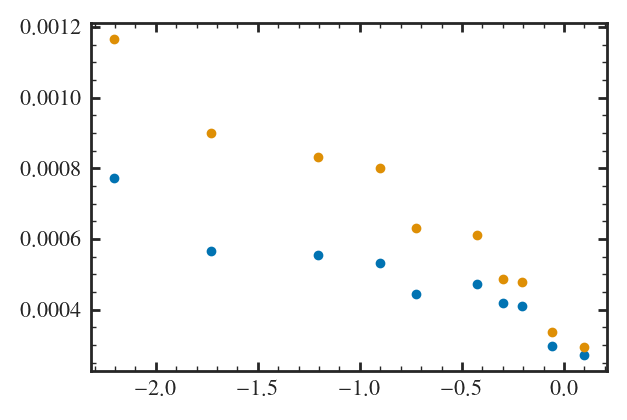

In [96]:
plt.scatter(obs[0], obs[1])
plt.scatter(obs0[0], obs0[1])

100%|██████████| 3000/3000 [00:11<00:00, 270.71it/s]


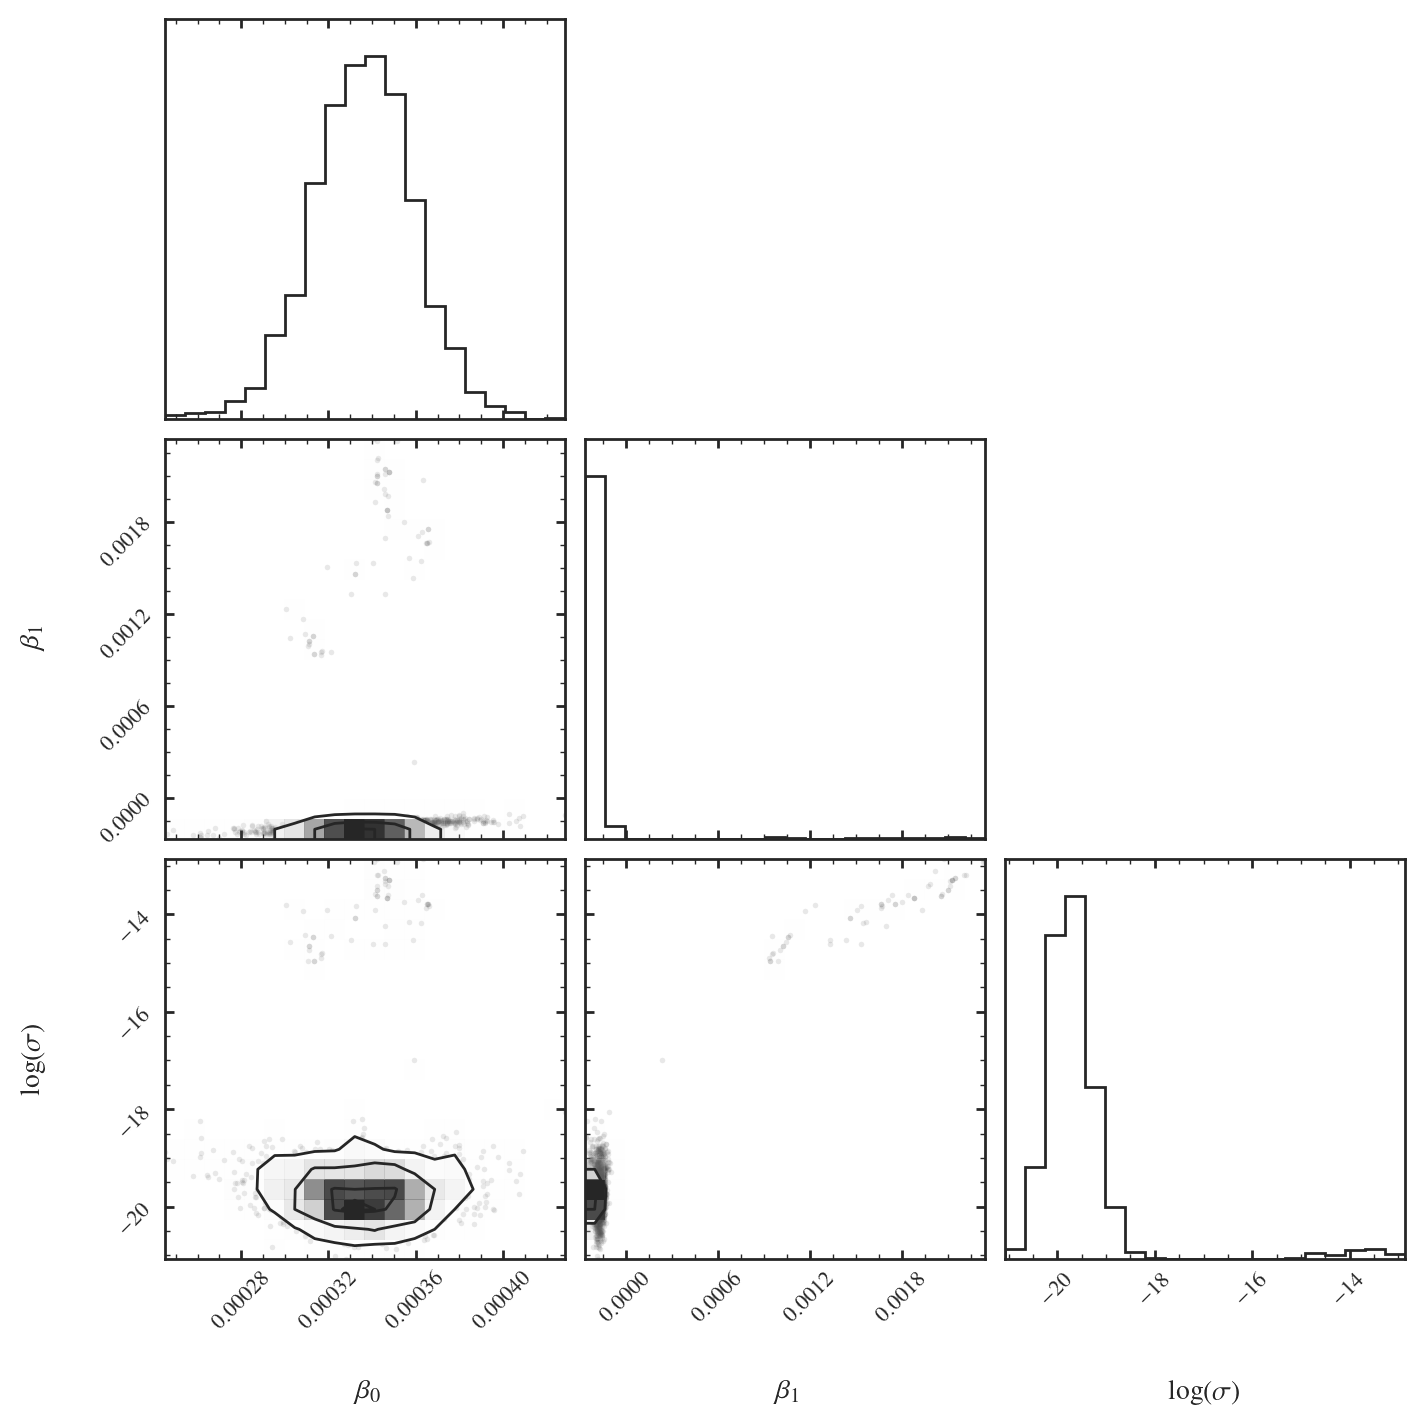

In [97]:
samples = mcmc_utils.run_mcmc(lin_model, obs, N=N, discard=discard)

$\beta_0$ = 3.36e-04 + 2.23e-05 - 2.21e-05
$\beta_1$ = -1.80e-04 + 2.32e-05 - 2.54e-05
$\log(\sigma)$ = -1.97e+01 + 4.09e-01 - 4.81e-01


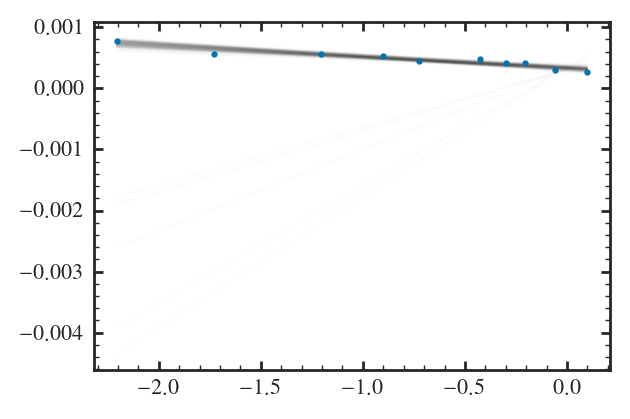

In [98]:
mcmc_utils.plot_posterior(lin_model, obs, samples)

100%|██████████| 3000/3000 [00:14<00:00, 209.06it/s]


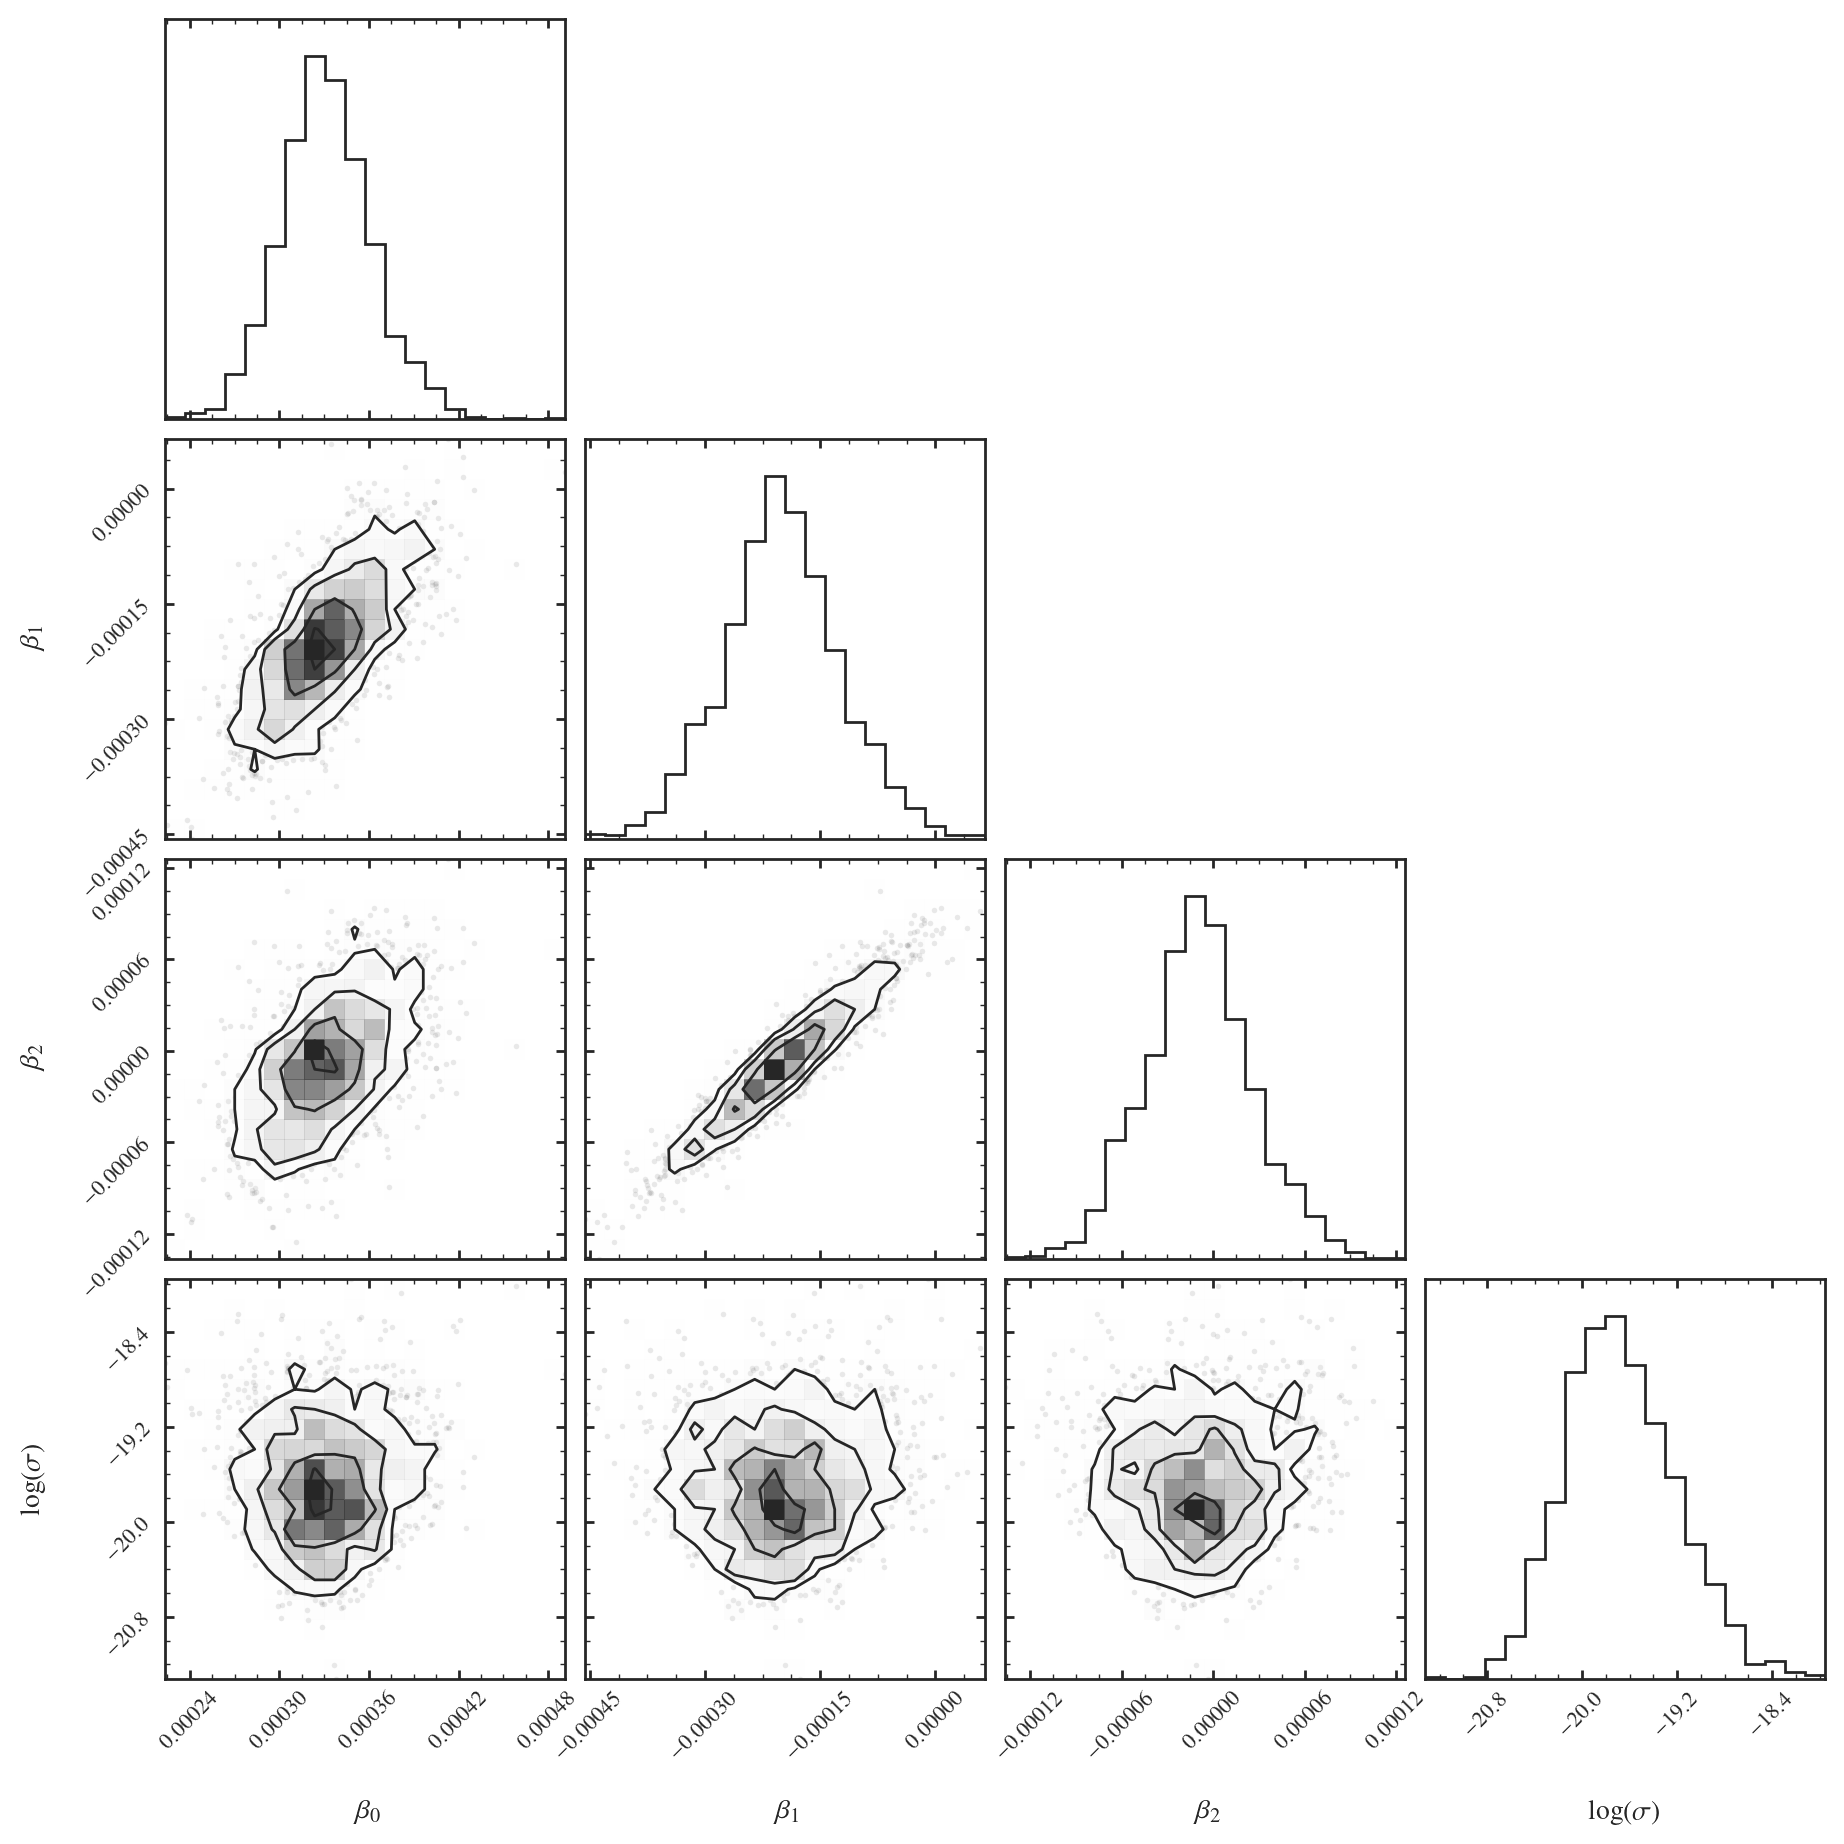

In [99]:
samples = mcmc_utils.run_mcmc(quad_model, obs, N=N, discard=discard)

$\beta_0$ = 3.30e-04 + 2.78e-05 - 3.05e-05
$\beta_1$ = -2.01e-04 + 7.26e-05 - 7.36e-05
$\beta_2$ = -1.00e-05 + 3.48e-05 - 3.48e-05
$\log(\sigma)$ = -1.97e+01 + 4.18e-01 - 5.04e-01


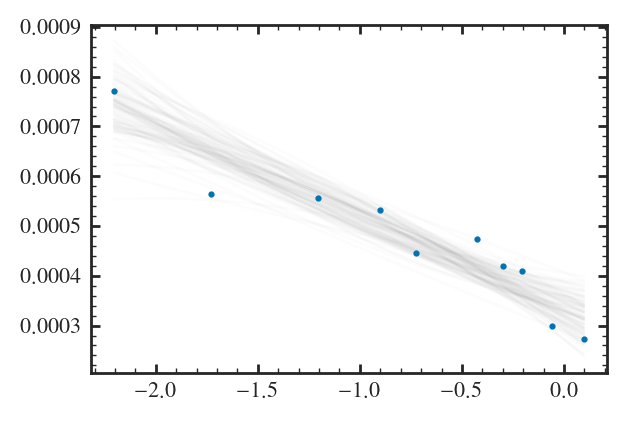

In [100]:
mcmc_utils.plot_posterior(quad_model, obs, samples)

100%|██████████| 3000/3000 [00:11<00:00, 251.24it/s]


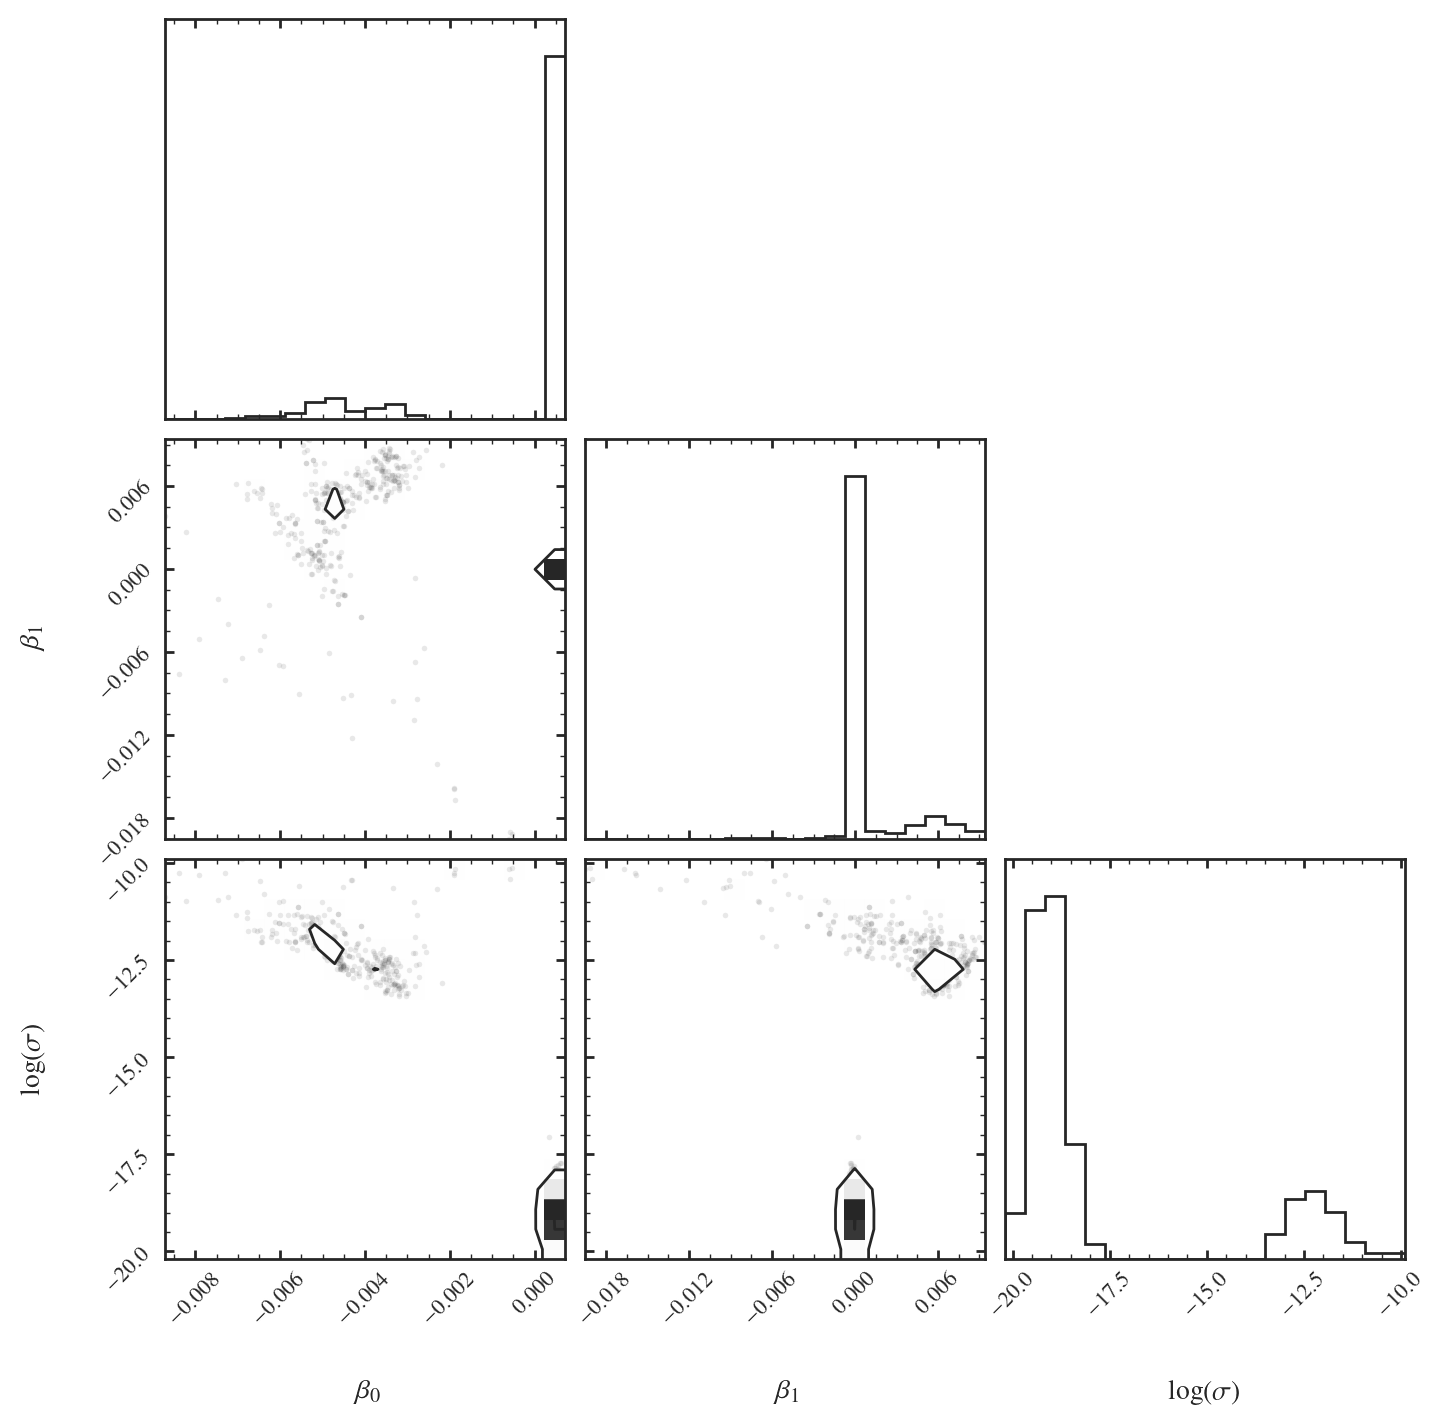

In [101]:
samples = mcmc_utils.run_mcmc(exp_model, obs, N=N, discard=discard)

$\beta_0$ = 5.87e-04 + 4.11e-03 - 3.59e-05
$\beta_1$ = -2.88e-04 + 6.69e-05 - 1.46e-03
$\log(\sigma)$ = -1.90e+01 + 4.66e-01 - 6.28e+00


(-0.001, 0.002)

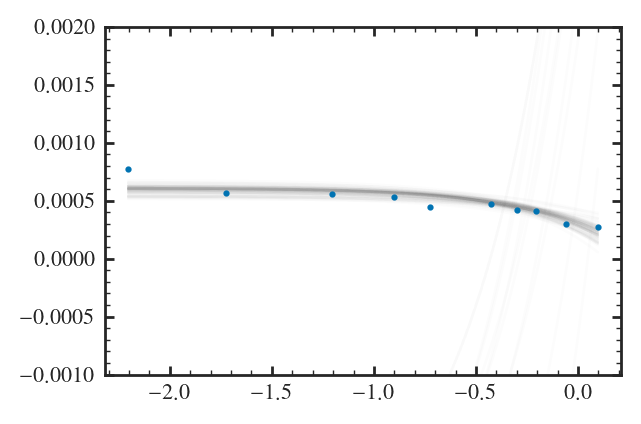

In [102]:
mcmc_utils.plot_posterior(exp_model, obs, samples)
plt.ylim(-1e-3, 2e-3)

In [103]:
get_yield_table

<function __main__.get_yield_table(study, **kwargs)>